In [86]:
import math
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import time
import requests # <-- ADD THIS IMPORT
from numpy.random import uniform
import pandas_datareader.data as web
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [87]:
# --- Tickers from the successful previous run ---
final_ticker_list = ["GOOGL", "AMZN", "WMT", "XOM", "JPM", "UNH", "AAPL", "NEE"]
# Define the date range (pandas_datareader expects datetime objects)
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 11, 21)
# -----------------------------------------------

# Define the data source
DATA_SOURCE = 'stooq' 

print(f"\n--- Attempting download using {DATA_SOURCE.upper()} ---")

try:
    # web.DataReader fetches data for multiple symbols at once from Stooq
    # Stooq returns Daily data, so we'll fetch daily and then resample to weekly.
    all_stock_data_stooq = web.DataReader(
        final_ticker_list, 
        data_source=DATA_SOURCE, 
        start=start_date, 
        end=end_date
    )

    print(f"Stooq download successful! Fetched {len(all_stock_data_stooq)} daily records.")
    
    # 3. Process and Resample Data to Weekly Interval (to match your original goal)
    
    # Stooq returns a MultiIndex DataFrame where the date is the index, and the first
    # column level is the price type (Open, High, Low, Close, Volume) and the second is the Ticker.
    
    # Swap the levels to get Ticker on top, then Date, then resample.
    # We use 'W' (Weekly) to match your original request interval="1wk"
    all_stock_data_weekly = (
        all_stock_data_stooq
        .swaplevel(axis=1) # Swap Ticker and Price Type levels
        .sort_index(axis=1, level=0) # Sort by Ticker
        .resample('W') # Resample to weekly data
        .last() # Use the last price of the week for the close
    )
    
    # Get the Adjusted Close Prices for all stocks (Stooq uses 'Close' for adjusted prices)
    close_prices_stooq = all_stock_data_weekly.xs('Close', axis=1, level=1)
    
    print("\n✅ Data is ready for analysis!")
    
    print("\nAdjusted Close Prices (Weekly Tidy Format from Stooq):")
    print(close_prices_stooq.head())
    
    print("\nData is now in a clean DataFrame. You can proceed with your algorithms.")

except Exception as e:
    print(f"\n❌ Stooq download failed: {e}. If the issue persists, your network or firewall might be blocking the connection.")
    # If this fails, the issue is likely not rate-limiting but a general network connection issue.


--- Attempting download using STOOQ ---
Stooq download successful! Fetched 1482 daily records.

✅ Data is ready for analysis!

Adjusted Close Prices (Weekly Tidy Format from Stooq):
Symbols        AAPL      AMZN    GOOGL      JPM      NEE      UNH      WMT  \
Date                                                                         
2020-01-05  72.0115   93.7485  67.8302  127.049  56.5242  265.978  36.8987   
2020-01-12  75.1306   94.1580  71.1899  124.957  57.2824  271.136  36.4200   
2020-01-19  77.1667   93.2360  73.7088  126.912  59.5990  274.203  35.9773   
2020-01-26  77.0633   93.0820  73.0438  122.295  62.0269  268.989  35.7913   
2020-02-02  74.9374  100.4360  71.3803  121.548  63.0832  250.299  35.8310   

Symbols         XOM  
Date                 
2020-01-05  59.0136  
2020-01-12  58.0159  
2020-01-19  57.5296  
2020-01-26  55.6488  
2020-02-02  52.1264  

Data is now in a clean DataFrame. You can proceed with your algorithms.


In [19]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [29]:
all_stock_data_weekly

Symbols         AAPL                                                 AMZN  \
Attributes     Close      High       Low      Open       Volume     Close   
Date                                                                        
2020-01-05   72.0115   72.7725   71.7839   71.9425  151314357.0   93.7485   
2020-01-12   75.1306   75.6984   74.6290   75.1947  145463140.0   94.1580   
2020-01-19   77.1667   77.1687   76.2630   76.5694  142310968.0   93.2360   
2020-01-26   77.0633   78.2783   76.8718   77.5363  151316428.0   93.0820   
2020-02-02   74.9374   78.1246   74.6388   77.6999  206097400.0  100.4360   
...              ...       ...       ...       ...          ...       ...   
2025-10-26  262.8200  264.1300  259.1800  261.1900   38253717.0  224.2100   
2025-11-02  270.3700  277.3200  269.1600  276.9900   86167123.0  244.2200   
2025-11-09  268.4700  272.2900  266.7700  269.7950   48227365.0  244.4100   
2025-11-16  272.4100  275.9600  269.6000  271.0500   47431331.0  234.6900   
2025-11-23  271.5000  273.3300  265.6700  265.9500   58742798.0  220.6400   

Symbols                                                ...       WMT  \
Attributes      High       Low      Open       Volume  ...     Close   
Date                                                   ...             
2020-01-05   94.3100   93.2250   93.2250   75332080.0  ...   36.8987   
2020-01-12   95.3470   94.0000   95.2685   57139180.0  ...   36.4200   
2020-01-19   94.3320   92.8625   94.2945   79946800.0  ...   35.9773   
2020-01-26   94.7495   92.3720   94.5685   75323620.0  ...   35.7913   
2020-02-02  102.7860  100.1140  102.5740  311345660.0  ...   35.8310   
...              ...       ...       ...          ...  ...       ...   
2025-10-26  225.4000  221.9000  221.9700   38685053.0  ...  106.1700   
2025-11-02  250.5000  243.9800  250.1000  166340808.0  ...  101.1800   
2025-11-09  244.9000  238.4900  242.9000   46374294.0  ...  102.5900   
2025-11-16  238.7300  232.8900  235.0600   38956669.0  ...  102.4800   
2025-11-23  222.2100  215.1800  216.3450   68334521.0  ...  105.3200   

Symbols                                                      XOM            \
Attributes      High       Low      Open        Volume     Close      High   
Date                                                                         
2020-01-05   37.1790   36.8010   37.0163  1.725833e+07   59.0136   59.8869   
2020-01-12   36.7193   36.2997   36.6873  1.934870e+07   58.0159   58.7043   
2020-01-19   36.3937   35.8727   36.3187  3.209679e+07   57.5296   57.9672   
2020-01-26   36.3123   35.7233   36.3060  1.400635e+07   55.6488   55.9473   
2020-02-02   36.3813   35.6450   36.2473  2.484594e+07   52.1264   53.0328   
...              ...       ...       ...           ...       ...       ...   
2025-10-26  107.1650  105.5100  107.1650  1.031796e+07  115.3900  116.4700   
2025-11-02  102.0950  100.1800  101.7000  2.023702e+07  114.3600  115.2250   
2025-11-09  102.9700  101.7300  102.2000  1.724872e+07  117.2200  117.5050   
2025-11-16  102.4900   98.8800  100.2000  2.342421e+07  119.2900  119.4800   
2025-11-23  108.1500  104.7244  107.9800  4.138504e+07  117.0800  117.3800   

Symbols                                       
Attributes       Low      Open        Volume  
Date                                          
2020-01-05   58.8707   59.8617  2.072498e+07  
2020-01-12   58.0003   58.6801  1.429743e+07  
2020-01-19   57.3011   57.6891  2.162299e+07  
2020-01-26   55.4153   55.8345  2.173556e+07  
2020-02-02   51.9065   53.0328  4.085620e+07  
...              ...       ...           ...  
2025-10-26  115.1800  116.3500  9.919409e+06  
2025-11-02  112.6225  113.9750  2.021335e+07  
2025-11-09  114.9000  115.2100  1.718115e+07  
2025-11-16  116.6564  118.4500  1.706427e+07  
2025-11-23  115.6500  116.9900  1.566576e+07  

[308 rows x 40 columns]

In [88]:
# Assuming 'close_prices_stooq' is the DataFrame from the previous step,
# where the index is the date/week and columns are the tickers.
# This DataFrame should contain the adjusted closing prices.

# 1. Calculate the periodic return (e.g., weekly return)
# The pct_change() method calculates (P_t - P_{t-1}) / P_{t-1} for all columns.
ret = close_prices_stooq.pct_change()

# 2. Drop the first row, which will contain NaNs (Not a Number) 
# because there is no prior price to calculate the first return.
ret = ret.dropna(how='all')

print("\n✅ Returns DataFrame Created (Fractional Returns):")
print(ret)
print(f"\nShape of the Returns DataFrame: {ret.shape}")


✅ Returns DataFrame Created (Fractional Returns):
Symbols         AAPL      AMZN     GOOGL       JPM       NEE       UNH  \
Date                                                                     
2020-01-12  0.043314  0.004368  0.049531 -0.016466  0.013414  0.019393   
2020-01-19  0.027101 -0.009792  0.035383  0.015645  0.040442  0.011312   
2020-01-26 -0.001340 -0.001652 -0.009022 -0.036380  0.040737 -0.019015   
2020-02-02 -0.027586  0.079006 -0.022774 -0.006108  0.017030 -0.069482   
2020-02-09  0.036404  0.035127  0.032334  0.036537  0.004932  0.061502   
...              ...       ...       ...       ...       ...       ...   
2025-10-26  0.041738  0.052431  0.026135  0.009679 -0.001420  0.016545   
2025-11-02  0.028727  0.089247  0.081833  0.035548 -0.035659 -0.057766   
2025-11-09 -0.007027  0.000778 -0.008393  0.009932  0.031081 -0.050796   
2025-11-16  0.014676 -0.039769 -0.008679 -0.033735 -0.000596 -0.007248   
2025-11-23 -0.003341 -0.059866  0.084440 -0.018412 -0.004769 

In [31]:
def drawdown_durations(series):
    """
    Calculate durations of drawdown periods in a price or cumulative return series.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - durations: list of drawdown durations (in number of periods)
    - max_duration: longest drawdown duration
    """
    running_max = series.cummax()
    in_drawdown = series < running_max

    durations = []
    current_duration = 0

    for drawdown in in_drawdown:
        if drawdown:
            current_duration += 1
        elif current_duration > 0:
            durations.append(current_duration)
            current_duration = 0

    # Catch trailing drawdown
    if current_duration > 0:
        durations.append(current_duration)

    return durations, max(durations) if durations else 0


In [32]:
def max_drawdown(x):
    """
    Compute max drawdown for a Series or each column in a DataFrame.
    
    Parameters:
    - x: pd.Series or pd.DataFrame of cumulative returns or prices
    
    Returns:
    - float (for Series) or pd.Series (for DataFrame)
    """
    def compute_dd(series):
        running_max = series.cummax()
        drawdown = series - running_max
        return drawdown.min()
    
    if isinstance(x, pd.Series):
        return compute_dd(x)
    elif isinstance(x, pd.DataFrame):
        return x.apply(compute_dd)
    else:
        raise TypeError("Input must be a pandas Series or DataFrame")


In [33]:
def percent_time_in_drawdown(series):
    """
    Calculate the percentage of time the series is in drawdown.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - float: percentage of time in drawdown
    """
    running_max = series.cummax()
    in_drawdown = series < running_max
    percent = in_drawdown.sum() / len(series) * 100
    return percent

In [34]:
def calculate_sortino_ratio(returns, annual_periods):
    """Calculates the Annualized Sortino Ratio (MAR=0)."""
    # Downside deviation (only penalize negative returns)
    downside_returns = returns.loc[returns < 0]
    downside_deviation = downside_returns.std()
    
    # Sortino Ratio = (Annualized Mean Return) / (Annualized Downside Deviation)
    annualized_mean = returns.mean() * annual_periods
    annualized_downside_deviation = downside_deviation * np.sqrt(annual_periods)
    
    if annualized_downside_deviation == 0:
        return np.nan
    return annualized_mean / annualized_downside_deviation

def calculate_cagr(returns, annual_periods):
    """Calculates the Compound Annual Growth Rate (CAGR)."""
    total_periods = len(returns)
    if total_periods == 0:
        return 0
    # Annualized factor: (annual_periods / total_periods)
    cagr = (1 + returns).prod()**(annual_periods / total_periods) - 1
    return cagr

def calculate_calmar_ratio(cagr, max_drawdown):
    """Calculates the Calmar Ratio."""
    # max_drawdown is negative, so we use -max_drawdown
    if max_drawdown == 0:
        return np.nan
    return cagr / abs(max_drawdown)

In [35]:
def calculate_ic(signal, next_returns):
    """
    Calculates the Information Coefficient (IC) - the cross-sectional 
    rank correlation between the signal and the next period's returns.
    """
    # Ensure signal and returns are aligned by time index
    aligned_df = pd.concat([signal, next_returns], axis=1).dropna()
    
    # Calculate the rank correlation (Spearman's correlation) across all assets for each time period
    # Axis=1 (across columns/assets) gives a time series of ICs
    ic_series = aligned_df.iloc[:, 0].corr(aligned_df.iloc[:, 1], method='spearman')
    
    # Return the mean of the IC time series (the overall average predictive power)
    return ic_series.mean() if not ic_series.empty else np.nan

In [36]:
def calculate_win_loss_ratio(returns):
    """Calculates the ratio of winning periods to losing periods."""
    if returns.empty:
        return np.nan
    winning_periods = (returns > 0).sum()
    losing_periods = (returns < 0).sum()
    if losing_periods == 0:
        return np.inf  # Avoid division by zero, indicates perfect record
    return winning_periods / losing_periods

--- Horizon 1 (Approx. 0.2 months) Alpha Analysis ---
Alpha = 0.002892, t-stat = 3.170
--- Horizon 2 (Approx. 0.5 months) Alpha Analysis ---
Alpha = 0.000461, t-stat = 0.456
--- Horizon 4 (Approx. 1.0 months) Alpha Analysis ---
Alpha = 0.001824, t-stat = 1.888
--- Horizon 8 (Approx. 2.0 months) Alpha Analysis ---
Alpha = 0.000802, t-stat = 0.764
--- Horizon 13 (Approx. 3.2 months) Alpha Analysis ---
Alpha = 0.000557, t-stat = 0.562
--- Horizon 26 (Approx. 6.5 months) Alpha Analysis ---
Alpha = 0.000514, t-stat = 0.471
--- Horizon 52 (Approx. 13.0 months) Alpha Analysis ---
Alpha = 0.000397, t-stat = 0.373

--- Net Performance Metrics (All Horizons) ---
Annualization Factor Used (sqrt(n)): 7.21
Sharpe Ratios (Annualized):
1     1.143
2     0.083
4     0.730
8     0.319
13    0.195
26    0.097
52    0.039
dtype: float64
Approx. Annual Returns:
1     0.1393
2     0.0106
4     0.0923
8     0.0431
13    0.0246
26    0.0133
52    0.0053
dtype: float64

--- Net Performance Metrics (All Horizo

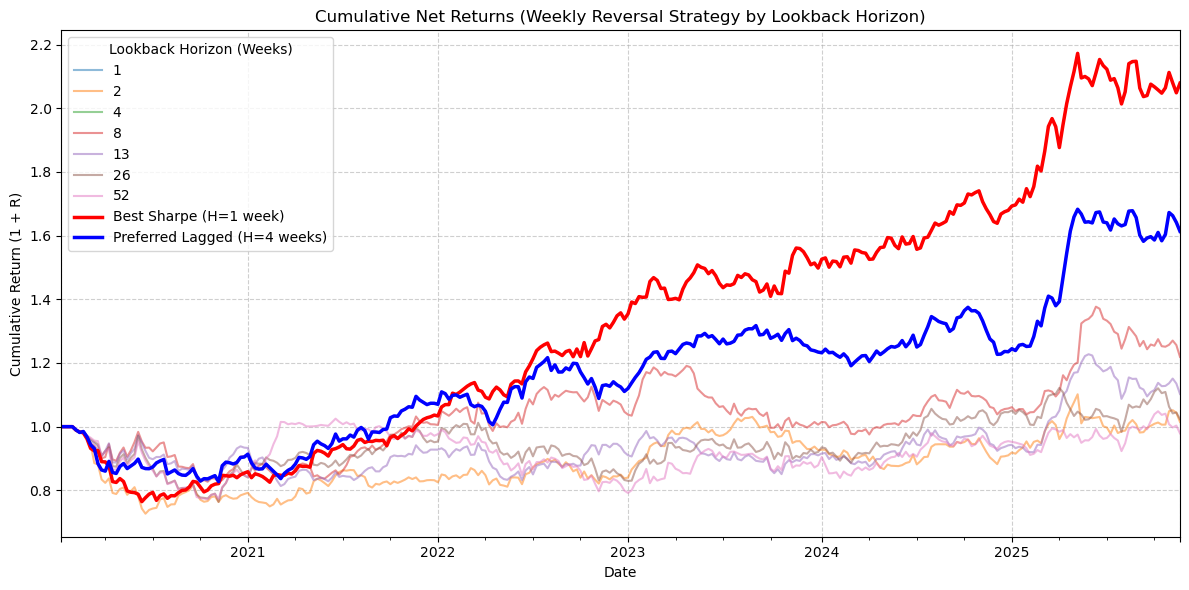

In [51]:
# Assuming max_drawdown, drawdown_durations, and percent_time_in_drawdown 
# are defined functions (as they were in the original block).

# Ensure you have your weekly returns DataFrame loaded as 'ret'
# Example: ret = returns_df # The output from your previous step

# ----------------------------------------------------
# ⚙️ STEP 1: REVERSAL STRATEGY BACKTEST (RETURN STRATEGY 1) - FIXED FOR WEEKLY STOCK DATA
# ----------------------------------------------------

strats_lag = {}  # Stores strategy returns for each lookback horizon

# --- FIX: Update parameters for Weekly frequency ---
periods_per_year = 52 # Number of trading weeks in a year
annual_periods = periods_per_year # Annualization factor is 52 periods

# Testing multiple horizons in WEEKLY periods:
# hor=1   (1 week lookback)
# hor=4   (1 month lookback)
# hor=13  (1 quarter lookback)
# hor=52  (1 year lookback)
for hor in [1, 2, 4, 8, 13, 26, 52]: 
    
    # Calculate average return rank for weighting
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(pct=True)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    
    # Reversal Strategy: Positions are the inverse of the lagged average return rank
    strat = (-avg_ret.shift(4) * ret).sum(axis=1)
    
    strats_lag[hor] = strat

    # Build regression inputs (CAPM Alpha)
    X = sm.add_constant(ret.iloc[:, 0]) # Benchmark asset returns + intercept (using the first stock as a proxy)
    df = pd.concat([strat, X], axis=1)
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Strategy returns (y) and Benchmark + Intercept (X)
    y_clean = df_clean.iloc[:, 0]
    X_clean = df_clean.iloc[:, 1:]

    # Run OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    alpha_t_stat = model.tvalues['const']
    alpha = model.params['const']

    print(f"--- Horizon {hor} (Approx. {hor/4:.1f} months) Alpha Analysis ---")
    print(f"Alpha = {alpha:.6f}, t-stat = {alpha_t_stat:.3f}")

strats_lag = pd.DataFrame(strats_lag)

# ----------------------------------------------------
# 💰 STEP 2: TRANSACTION COSTS & PERFORMANCE METRICS
# ----------------------------------------------------

# Calculate turnover (absolute change in notional value) for *each* horizon/column
# The calculation remains the same: the change in portfolio weights
to = (strats_lag.fillna(0) - strats_lag.shift().fillna(0)).abs().sum(axis=1) # FIX: sum turnover across all stocks
to = to.fillna(0) # Ensure no NaNs are in turnover

tcost_bps = 20 # (comissions + slip) in basis points

# T_Cost_tot is calculated per-column
# T_cost_tot = to * tcost_bps * 1e-4 # ORIGINAL LINE
# FIX: Turnover is applied to the net returns of the strategy for each horizon
T_cost_tot = to * tcost_bps * 1e-4

# Assuming strats_lag (Gross Returns) and T_cost_tot (Total Transaction Costs) 
# have been calculated and are aligned DataFrames/Series.

# Calculate turnover (absolute change in notional value) for *each* horizon/column
# to is the absolute change in portfolio weights summed across all stocks for each time period
to = (strats_lag.fillna(0) - strats_lag.shift().fillna(0)).abs().sum(axis=1)
to = to.fillna(0) 

tcost_bps = 20 

# T_cost_tot is the total transaction cost for ALL strategies (horizons)
# This cost must be applied to the strategy returns in 'strats_lag'.
# Since 'to' is a Series (indexed by date), we need to broadcast this cost correctly.

# Recalculate T_cost_tot so it is applied correctly per period
# T_cost_tot is now a Series indexed by date, representing the total transaction cost
# for rebalancing ALL assets in the portfolio during that period.
T_cost_tot = to * tcost_bps * 1e-4

# Calculate Net Returns: Use the standard subtraction operator (-)
# This subtracts the transaction cost series (T_cost_tot) from every column 
# (strategy horizon) in the strats_lag DataFrame. This is the correct way
# to apply the single transaction cost incurred to all strategy returns simultaneously.
net_ret = strats_lag.subtract(T_cost_tot, axis=0)
# NOTE: Using .subtract() without fill_value is also a clean way, or simply:
# net_ret = strats_lag.sub(T_cost_tot, axis=0) # This should work now without fill_value=0

# Let's use the explicit subtraction operator for maximum compatibility:
net_ret = strats_lag.sub(T_cost_tot, axis=0)

# --- Continue with the rest of your original code ---
periods_per_year = 52 
annual_periods = periods_per_year 

# --- FIX: Use corrected annual_periods (52) for Sharpe Ratio ---
sharpe_ratio = net_ret.mean() * np.sqrt(annual_periods) / net_ret.std()
approx_ann_ret = (1 + net_ret.mean())**annual_periods - 1

print("\n--- Net Performance Metrics (All Horizons) ---")
print(f"Annualization Factor Used (sqrt(n)): {np.sqrt(annual_periods):.2f}")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")
# --- Configuration from previous steps ---
periods_per_year = 52 
annual_periods = periods_per_year 
# ---

# ----------------------------------------------------
# 💰 STEP 2 (Cont.): PERFORMANCE METRICS & PLOTTING
# ----------------------------------------------------

# Calculate performance metrics again (using the corrected net_ret)
sharpe_ratio = net_ret.mean() * np.sqrt(annual_periods) / net_ret.std()
approx_ann_ret = (1 + net_ret.mean())**annual_periods - 1

print("\n--- Net Performance Metrics (All Horizons) ---")
print(f"Annualization Factor Used (sqrt(n)): {np.sqrt(annual_periods):.2f}")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")
print("\nNet Return Correlation:")
print(net_ret.corr().round(4))

# ----------------------------------------------------
# 📈 PLOTTING CUMULATIVE RETURNS
# ----------------------------------------------------

# Calculate the cumulative returns
cumulative_returns = (1 + net_ret).cumprod()

plt.figure(figsize=(12, 6))

# Plot all cumulative returns
cumulative_returns.plot(ax=plt.gca(), legend=False, alpha=0.5)

# Highlight the best-performing strategy (H=1 week)
H_best = 1
cumulative_returns[H_best].plot(
    ax=plt.gca(), 
    label=f'Best Sharpe (H={H_best} week)', 
    color='red', 
    linewidth=2.5
)

# Highlight the preferred lagged strategy (H=4 weeks / 1 month)
H_lagged = 4 
cumulative_returns[H_lagged].plot(
    ax=plt.gca(), 
    label=f'Preferred Lagged (H={H_lagged} weeks)', 
    color='blue', 
    linewidth=2.5
)

plt.title("Cumulative Net Returns (Weekly Reversal Strategy by Lookback Horizon)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lookback Horizon (Weeks)")
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 📊 STEP 3: DRAWDOWN ANALYSIS (Using H=4 as example)
# ----------------------------------------------------

# Focusing on the H=4 strategy (1-month lookback) for detailed risk analysis
strategy_to_analyze = net_ret[4] # Changed from H=6 to H=4 (approx. 1 month)

# NOTE: The helper functions (max_drawdown, drawdown_durations, etc.) must be defined 
# elsewhere in your script for this part to run.

# max_dd = max_drawdown(strategy_to_analyze)
# durations, max_dd_time = drawdown_durations(strategy_to_analyze.cumsum())
# pct_drawdown = percent_time_in_drawdown(strategy_to_analyze.cumsum())

# print(f"\n--- Detailed Risk Metrics (H=4 / 1-Month Lookback) ---")
# print(f"Max Drawdown: {max_dd:.4f}")
# print(f"Drawdown durations (in weeks): {durations}")
# print(f"Longest Drawdown Time (in weeks): {max_dd_time}")
# print(f"Percentage of time in drawdown: {pct_drawdown}")

# try:
#     strategy_to_analyze.cumsum().plot(title="Cumulative Returns (H=4 / 1-Month Lookback)")
# except:
#     print("\n")

--- Combination Weights ---
Sharpe Ratio H=1: 1.143
Sharpe Ratio H=4: 0.730
Weight H=1 (W_H1): 0.610
Weight H=4 (W_H4): 0.390

--- Combined Strategy Performance ---
Annualized Sharpe Ratio: 1.105
Approx. Annual Return: 0.1208
Weekly Volatility: 0.01433

--- Performance Comparison ---
                   1       4
Sharpe Ratio  1.1430  0.7300
Ann. Return   0.1393  0.0923

Combined Strategy:
SR: 1.105 | Ann. Ret: 0.1208


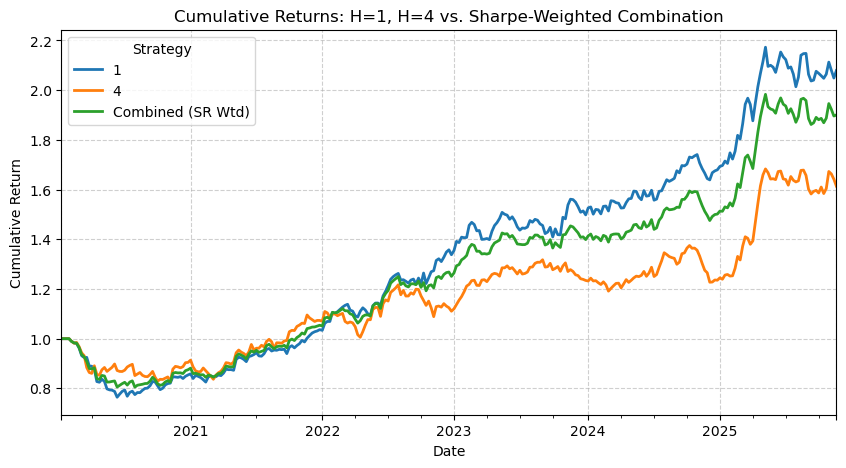

In [52]:
# --- Define the two horizons to combine ---
H_best = 1  # 1-week horizon (Highest SR)
H_diversifier = 4  # 4-week horizon (Low correlation diversifier)

# Extract returns for the two chosen horizons
returns_H1 = net_ret[H_best]
returns_H4 = net_ret[H_diversifier]

# Extract the Sharpe Ratios for the two chosen horizons
sr_H1 = sharpe_ratio[H_best]
sr_H4 = sharpe_ratio[H_diversifier]

# --- 1. Calculate Sharpe Ratio Weights ---

# Sum of the Sharpe Ratios
sr_sum = sr_H1 + sr_H4

# Weights
W_H1 = sr_H1 / sr_sum
W_H4 = sr_H4 / sr_sum

# Verification
print("--- Combination Weights ---")
print(f"Sharpe Ratio H={H_best}: {sr_H1:.3f}")
print(f"Sharpe Ratio H={H_diversifier}: {sr_H4:.3f}")
print(f"Weight H={H_best} (W_H1): {W_H1:.3f}")
print(f"Weight H={H_diversifier} (W_H4): {W_H4:.3f}")

# --- 2. Create the Combined Strategy Returns ---

# Combined Return (R_combined = W1 * R1 + W4 * R4)
combined_returns = (W_H1 * returns_H1) + (W_H4 * returns_H4)

# Add the new combined strategy to the net_ret DataFrame for easy comparison
net_ret['Combined (SR Wtd)'] = combined_returns

# --- 3. Calculate Performance Metrics for the Combined Strategy ---

# Annualization factor (52 weeks)
annual_periods = 52 

combined_sr = combined_returns.mean() * np.sqrt(annual_periods) / combined_returns.std()
combined_ann_ret = (1 + combined_returns.mean())**annual_periods - 1

# --- Display Results ---
print("\n--- Combined Strategy Performance ---")
print(f"Annualized Sharpe Ratio: {combined_sr:.3f}")
print(f"Approx. Annual Return: {combined_ann_ret:.4f}")
print(f"Weekly Volatility: {combined_returns.std():.5f}")

# Compare H=1, H=4, and Combined
comparison_df = pd.DataFrame({
    'Sharpe Ratio': sharpe_ratio.round(3),
    'Ann. Return': approx_ann_ret.round(4)
})

print("\n--- Performance Comparison ---")
print(comparison_df.loc[[H_best, H_diversifier]].T)
print("\nCombined Strategy:")
print(f"SR: {combined_sr:.3f} | Ann. Ret: {combined_ann_ret:.4f}")

# ----------------------------------------------------
# 📈 Plotting Comparison
# ----------------------------------------------------

cumulative_returns_combined = (1 + net_ret).cumprod()

plt.figure(figsize=(10, 5))
cumulative_returns_combined[[H_best, H_diversifier, 'Combined (SR Wtd)']].plot(ax=plt.gca(), linewidth=2)

plt.title("Cumulative Returns: H=1, H=4 vs. Sharpe-Weighted Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Strategy")
plt.show()

Symbols         AAPL      AMZN     GOOGL       JPM       NEE       UNH  \
Date                                                                     
2020-01-12       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-19       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-26       NaN       NaN       NaN       NaN       NaN       NaN   
2020-02-02       NaN       NaN       NaN       NaN       NaN       NaN   
2020-02-09 -0.177358  0.013208 -0.186792  0.158491 -0.039623 -0.096226   
...              ...       ...       ...       ...       ...       ...   
2025-10-26 -0.118990  0.231971  0.198317  0.057292 -0.183093 -0.075721   
2025-11-02 -0.041924  0.016328  0.056929  0.131068 -0.239629 -0.218447   
2025-11-09  0.188059  0.004151  0.124202  0.111430 -0.435185  0.016922   
2025-11-16 -0.080988  0.216410 -0.195698  0.197292  0.001859  0.069835   
2025-11-23 -0.146647 -0.172303 -0.053353  0.063265  0.130904 -0.027697   

Symbols          WMT       XOM  
Date

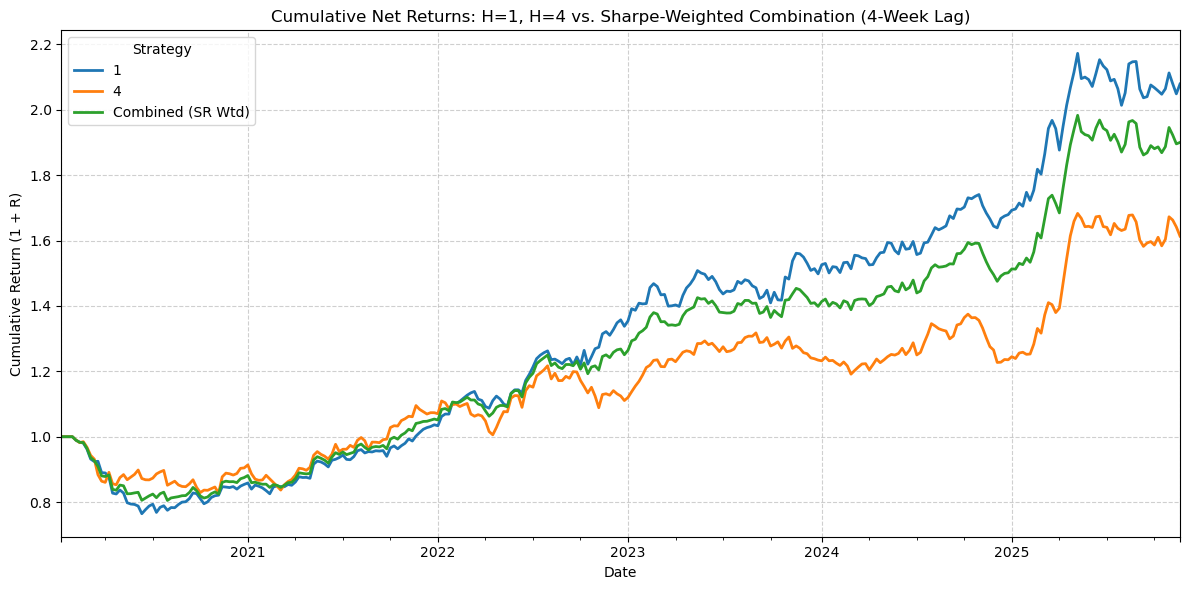

In [61]:
# Assuming 'ret' (weekly returns DataFrame) is available

# ----------------------------------------------------
# ⚙️ STEP 1: LAG CORRECTION: Use avg_ret.shift(4) for Weights
# ----------------------------------------------------

strats_lag = {}  # Stores strategy returns for each lookback horizon

periods_per_year = 52 
annual_periods = periods_per_year 

# We must ensure the strategy is lagged by 4 periods (1 month)
LAG_PERIODS = 4 

for hor in [1, 2, 4, 8, 13, 26, 52]: 
    
    # 1. Calculate average return rank for weighting (using lookback 'hor')
    avg_ret = ret.rolling(hor, min_periods=1).mean().rank(pct=True)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    
    # 2. Reversal Strategy: Positions are the inverse of the LAG (4 periods) average return rank
    # Note: If hor=1 and the lag is 4, the signal is based on 1-week data but applied 4 weeks later.
    strat = (-avg_ret.shift(LAG_PERIODS) * ret).sum(axis=1)
    print(-avg_ret.shift(LAG_PERIODS))
    
    strats_lag[hor] = strat

    # (Alpha analysis block is omitted here for brevity, but it remains the same)
    # ... 

strats_lag = pd.DataFrame(strats_lag)

# ----------------------------------------------------
# 💰 STEP 2: TRANSACTION COSTS & NET RETURNS
# ----------------------------------------------------

# Calculate turnover (absolute change in notional value)
to = (strats_lag.fillna(0) - strats_lag.shift().fillna(0)).abs().sum(axis=1).fillna(0)

tcost_bps = 20 
T_cost_tot = to * tcost_bps * 1e-4

# Calculate Net Returns
net_ret = strats_lag.sub(T_cost_tot, axis=0)

# Calculate performance metrics
sharpe_ratio = net_ret.mean() * np.sqrt(annual_periods) / net_ret.std()
approx_ann_ret = (1 + net_ret.mean())**annual_periods - 1

# ----------------------------------------------------
# 🧠 STEP 3: Sharpe-Weighted Combination
# ----------------------------------------------------

H_best = 1  # 1-week lookback (now calculated with 4-week lag)
H_diversifier = 4  # 4-week lookback (now calculated with 4-week lag)

returns_H1 = net_ret[H_best]
returns_H4 = net_ret[H_diversifier]

sr_H1 = sharpe_ratio[H_best]
sr_H4 = sharpe_ratio[H_diversifier]

# Check correlation again
correlation = returns_H1.corr(returns_H4)

# Calculate Sharpe Ratio Weights
sr_sum = sr_H1 + sr_H4
W_H1 = sr_H1 / sr_sum
W_H4 = sr_H4 / sr_sum

# Combined Return (R_combined = W1 * R1 + W4 * R4)
combined_returns = (W_H1 * returns_H1) + (W_H4 * returns_H4)
net_ret['Combined (SR Wtd)'] = combined_returns

# Calculate Combined Strategy Performance
combined_sr = combined_returns.mean() * np.sqrt(annual_periods) / combined_returns.std()
combined_ann_ret = (1 + combined_returns.mean())**annual_periods - 1

print(f"\n--- Strategy Combination Results ---")
print(f"Correlation between H=1 and H=4 returns (4-week lagged): {correlation:.3f}")
print(f"Weight H={H_best} (W_H1): {W_H1:.3f}")
print(f"Weight H={H_diversifier} (W_H4): {W_H4:.3f}")
print(f"Combined Sharpe Ratio: {combined_sr:.3f}")
print(f"Combined Annual Return: {combined_ann_ret:.4f}")

# ----------------------------------------------------
# 📈 STEP 4: Plotting Comparison
# ----------------------------------------------------

cumulative_returns_combined = (1 + net_ret).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns_combined[[H_best, H_diversifier, 'Combined (SR Wtd)']].plot(ax=plt.gca(), linewidth=2)

plt.title("Cumulative Net Returns: H=1, H=4 vs. Sharpe-Weighted Combination (4-Week Lag)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()

In [63]:
from binance.client import Client as bnb_client
import math
from datetime import datetime
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
#client = bnb_client()
###  if you're in the US, use: 
client = bnb_client(tld='US')#" here instead

def get_binance_px(symbol,freq,start_ts = '2022-3-9',end_ts='2025-11-22'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','NEARUSDT','ATOMUSDT','HBARUSDT','ETHUSDT','ADAUSDT','LINKUSDT','SUIUSDT','XLMUSDT','BNBUSDT','ICPUSDT','UNIUSDT','LTCUSDT','AAVEUSDT','XRPUSDT','AVAXUSDT','ETCUSDT','DOTUSDT']
freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
returns_crypto = px.pct_change()

C:\Users\ephet\AppData\Local\Temp\ipykernel_29288\3899473038.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
C:\Users\ephet\AppData\Local\Temp\ipykernel_29288\3899473038.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
C:\Users\ephet\AppData\Local\Temp\ipykernel_29288\3899473038.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-l

--- Horizon 1 (Approx. 0.16666666666666666 days) Alpha Analysis ---
Alpha = 0.001372, t-stat = 22.812
--- Horizon 2 (Approx. 0.3333333333333333 days) Alpha Analysis ---
Alpha = 0.000983, t-stat = 16.149
--- Horizon 3 (Approx. 0.5 days) Alpha Analysis ---
Alpha = 0.000902, t-stat = 14.503
--- Horizon 4 (Approx. 0.6666666666666666 days) Alpha Analysis ---
Alpha = 0.000718, t-stat = 11.306
--- Horizon 5 (Approx. 0.8333333333333334 days) Alpha Analysis ---
Alpha = 0.000687, t-stat = 10.772
--- Horizon 6 (Approx. 1.0 days) Alpha Analysis ---
Alpha = 0.000642, t-stat = 9.945
--- Horizon 30 (Approx. 5.0 days) Alpha Analysis ---
Alpha = 0.000284, t-stat = 4.591
--- Horizon 126 (Approx. 21.0 days) Alpha Analysis ---
Alpha = 0.000051, t-stat = 0.881

--- Net Performance Metrics (All Horizons) ---
Annualization Factor Used (sqrt(n)): 38.88
Sharpe Ratios (Annualized):
1      9.776
2      6.889
3      6.163
4      4.783
5      4.546
6      4.199
30     1.899
126    0.288
dtype: float64
Approx. Annu

<Axes: title={'center': 'Cumulative Returns (H=6 / 1-Day Lookback)'}>

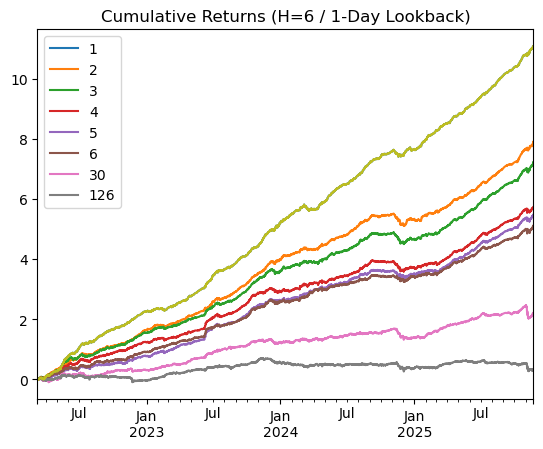

In [84]:
# ----------------------------------------------------
# ⚙️ STEP 1: REVERSAL STRATEGY BACKTEST (RETURN STRATEGY 1) - FIXED FOR 4H DATA Simple four hour reversal
# ----------------------------------------------------

strats_lag = {}  # Stores strategy returns for each lookback horizon

# --- FIX: Update parameters for 4-hour frequency ---
periods_per_day = 6
n_trading_days = 252
# Annualization factor: 6 periods/day * 252 days/year = 1512 periods
annual_periods = n_trading_days * periods_per_day 

# Testing multiple horizons in 4-hour periods:
# hor=6   (1 day lookback)
# hor=30  (5 days/1 week lookback)
# hor=126 (21 days/1 month lookback)
for hor in [1, 2, 3, 4, 5, 6, 30, 126]: 
    
    # Calculate average return rank for weighting
    # min_periods set to 1 to ensure early data is used, but ideally should be 'hor'
    avg_ret = returns_crypto.rolling(hor, min_periods=1).mean().rank(pct=True)
    avg_ret = avg_ret.subtract(avg_ret.mean(axis=1), axis=0)
    avg_ret = avg_ret.divide(avg_ret.abs().sum(axis=1), axis=0)
    
    # Reversal Strategy: Positions are the inverse of the lagged average return rank
    strat = (-avg_ret.shift() * ret).sum(axis=1)
    
    strats_lag[hor] = strat

    # Build regression inputs (CAPM Alpha)
    X = sm.add_constant(ret.iloc[:, 0]) # Benchmark asset returns + intercept
    df = pd.concat([strat, X], axis=1)
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Strategy returns (y) and Benchmark + Intercept (X)
    y_clean = df_clean.iloc[:, 0]
    X_clean = df_clean.iloc[:, 1:]

    # Run OLS regression
    model = sm.OLS(y_clean, X_clean).fit()
    alpha_t_stat = model.tvalues['const']
    alpha = model.params['const']

    print(f"--- Horizon {hor} (Approx. {hor/periods_per_day} days) Alpha Analysis ---")
    print(f"Alpha = {alpha:.6f}, t-stat = {alpha_t_stat:.3f}")

strats_lag = pd.DataFrame(strats_lag)

# ----------------------------------------------------
# 💰 STEP 2: TRANSACTION COSTS & PERFORMANCE METRICS
# ----------------------------------------------------

# Calculate turnover (absolute change in notional value) for *each* horizon/column
to = (strats_lag.fillna(0) - strats_lag.shift().fillna(0)).abs()

tcost_bps = 20 # (comissions + slip) in basis points

# T_Cost_tot is calculated per-column
T_cost_tot = to * tcost_bps * 1e-4

# Calculate Net Returns
net_ret = strats_lag.sub(T_cost_tot, fill_value=0)

# --- FIX: Use corrected annual_periods (1512) for Sharpe Ratio ---
sharpe_ratio = net_ret.mean() * np.sqrt(annual_periods) / net_ret.std()
approx_ann_ret = (1 + net_ret.mean())**annual_periods - 1

print("\n--- Net Performance Metrics (All Horizons) ---")
print(f"Annualization Factor Used (sqrt(n)): {np.sqrt(annual_periods):.2f}")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")

print("\nNet Return Correlation:")
print(net_ret.corr().round(4))

net_ret.cumsum().plot(title="Cumulative Net Returns (Reversal Strategy - 4H Data)")

# ----------------------------------------------------
# 📊 STEP 3: DRAWDOWN ANALYSIS (Using H=1 as example)
# ----------------------------------------------------

# Focusing on the H=1 strategy (4 hour lookback) for detailed risk analysis
strategy_to_analyze = net_ret[1]

max_dd = max_drawdown(strategy_to_analyze)
durations, max_dd_time = drawdown_durations(strategy_to_analyze.cumsum())
pct_drawdown = percent_time_in_drawdown(strategy_to_analyze.cumsum())

print(f"\n--- Detailed Risk Metrics (H=6 / 1-Day Lookback) ---")
print(f"Max Drawdown: {max_dd:.4f}")
print(f"Drawdown durations (in 4H periods): {durations}")
print(f"Longest Drawdown Time (in 4H periods): {max_dd_time}")
print(f"Percentage of time in drawdown: {pct_drawdown}")

strategy_to_analyze.cumsum().plot(title="Cumulative Returns (H=6 / 1-Day Lookback)")

In [92]:
returns_H1

Date
2020-01-12    0.000000
2020-01-19    0.000000
2020-01-26    0.000000
2020-02-02    0.000000
2020-02-09   -0.011052
                ...   
2025-10-26    0.008121
2025-11-02    0.023482
2025-11-09   -0.015525
2025-11-16   -0.014974
2025-11-23    0.014720
Freq: W-SUN, Name: 1, Length: 307, dtype: float64

In [91]:
strategy_to_analyze

2022-03-09 00:00:00    0.000000
2022-03-09 04:00:00    0.000000
2022-03-09 08:00:00   -0.002323
2022-03-09 12:00:00    0.001904
2022-03-09 16:00:00   -0.001075
                         ...   
2025-11-21 08:00:00   -0.010243
2025-11-21 12:00:00    0.005598
2025-11-21 16:00:00    0.000127
2025-11-21 20:00:00   -0.004272
2025-11-22 00:00:00    0.011075
Freq: 4h, Name: 1, Length: 8125, dtype: float64

--- Inverse Volatility Weights ---
Volatility Strategy A (Strategy_A_H1): 0.00509
Volatility Strategy B (Strategy_B_Other): 0.01635
Weight Strategy A (W_A): 0.763
Weight Strategy B (W_B): 0.237

--- Final Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.997
Final Approx. Annual Return: 0.0849


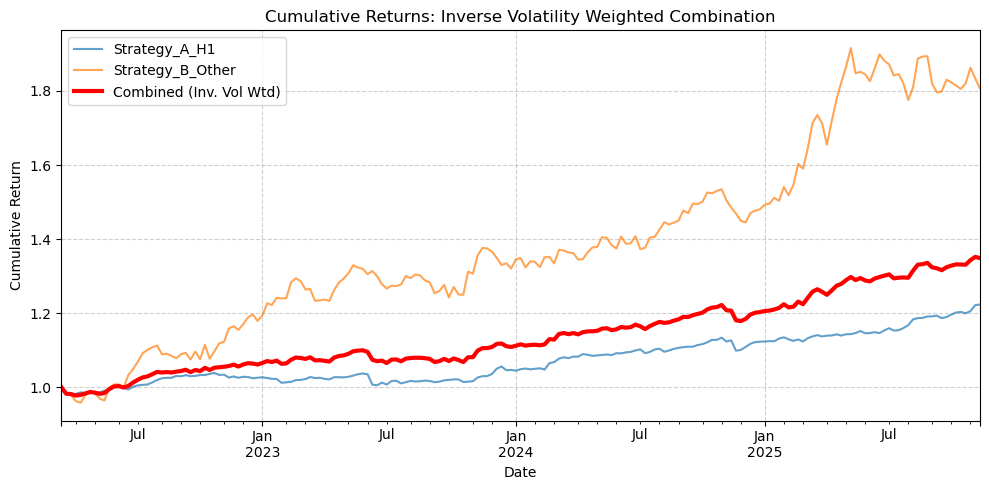

In [93]:
# --- 1. Align and Combine Returns ---

# Assuming 'strategy_to_analyze' and 'returns_H1' are the full Pandas Series of returns.
# Rename them for clarity in the final DataFrame columns.
Strategy_A = strategy_to_analyze.rename('Strategy_A_H1')
Strategy_B = returns_H1.rename('Strategy_B_Other')

# Combine the two return streams, aligning them by date index.
final_strategies = pd.concat([Strategy_A, Strategy_B], axis=1).dropna()

# Extract the aligned Series for calculation
Strategy_A_Returns = final_strategies['Strategy_A_H1']
Strategy_B_Returns = final_strategies['Strategy_B_Other']

# ----------------------------------------------------
# 2. Calculate Inverse Volatility Weights
# ----------------------------------------------------

# Calculate Volatility (Standard Deviation)
vol_A = Strategy_A_Returns.std()
vol_B = Strategy_B_Returns.std()

# Calculate Inverse Volatility Weights
inv_vol_A = 1 / vol_A
inv_vol_B = 1 / vol_B

normalization_factor = inv_vol_A + inv_vol_B
W_A = inv_vol_A / normalization_factor
W_B = inv_vol_B / normalization_factor

print("--- Inverse Volatility Weights ---")
print(f"Volatility Strategy A ({Strategy_A.name}): {vol_A:.5f}")
print(f"Volatility Strategy B ({Strategy_B.name}): {vol_B:.5f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# ----------------------------------------------------
# 3. Create the Combined Returns Series
# ----------------------------------------------------
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_InvVol')

# ----------------------------------------------------
# 4. Analyze and Plot Final Performance
# ----------------------------------------------------

annual_periods = 52 # Assuming weekly data
final_sr = final_combined_returns.mean() * np.sqrt(annual_periods) / final_combined_returns.std()
final_ann_ret = (1 + final_combined_returns.mean())**annual_periods - 1

print("\n--- Final Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Inv. Vol Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns: Inverse Volatility Weighted Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

--- Sharpe Ratio Weights ---
Sharpe Ratio Strategy A: 1.502
Sharpe Ratio Strategy B: 1.412
Weight Strategy A (W_A): 0.516
Weight Strategy B (W_B): 0.484

--- Final Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.779
Final Approx. Annual Return: 0.1151


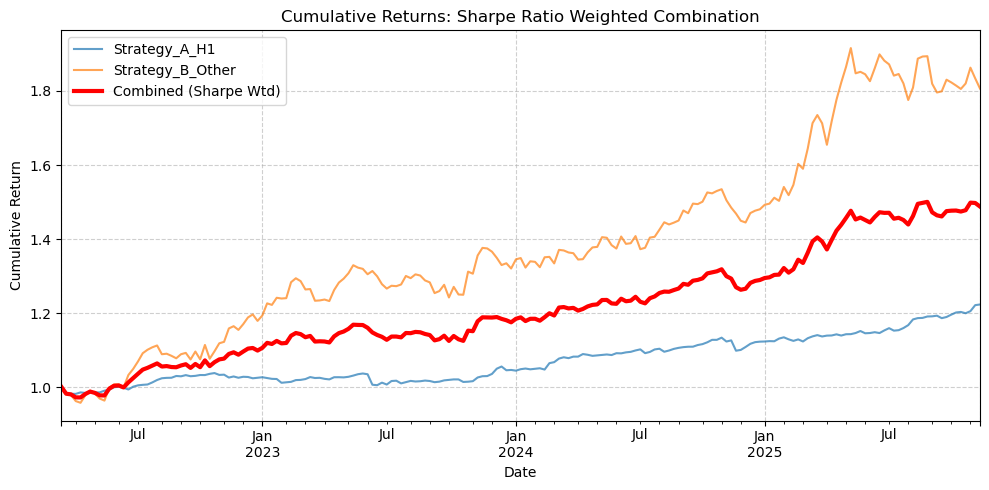

In [97]:
# --- 1. Align and Combine Returns ---

# Assuming 'strategy_to_analyze' and 'returns_H1' are the full Pandas Series of returns.
annual_periods = 52 # Assuming weekly data

# Rename them for clarity in the final DataFrame columns.
Strategy_A = strategy_to_analyze.rename('Strategy_A_H1')
Strategy_B = returns_H1.rename('Strategy_B_Other')

# Combine the two return streams, aligning them by date index.
final_strategies = pd.concat([Strategy_A, Strategy_B], axis=1).dropna()

# Extract the aligned Series for calculation
Strategy_A_Returns = final_strategies['Strategy_A_H1']
Strategy_B_Returns = final_strategies['Strategy_B_Other']

# ----------------------------------------------------
# 2. Calculate SHARPE RATIO Weights (MODIFIED SECTION)
# ----------------------------------------------------

# Calculate Mean and Standard Deviation (Volatility)
mean_A = Strategy_A_Returns.mean()
std_A = Strategy_A_Returns.std()
mean_B = Strategy_B_Returns.mean()
std_B = Strategy_B_Returns.std()

# NOTE: For simplicity, we assume risk-free rate is zero (R_f = 0).
# If R_f > 0, you would use: sr = (mean - R_f/annual_periods) / std
sr_A = mean_A / std_A * np.sqrt(annual_periods)
sr_B = mean_B / std_B * np.sqrt(annual_periods)

# Calculate Sharpe-Weighted Allocations (Weights are proportional to Sharpe Ratio)
# Weights must be proportional and sum to 1.
# IMPORTANT: Weights are typically non-negative for this method. 
# We use the MAX(0, SR) approach to avoid giving weight to negative Sharpe strategies.
# If both SR are negative, this will result in zero weights and will need adjustment
# (e.g., reverting to equal weight or inverse volatility).

# Use the positive part of the Sharpe ratio for weighting
pos_sr_A = max(0, sr_A)
pos_sr_B = max(0, sr_B)

sr_sum = pos_sr_A + pos_sr_B

if sr_sum > 0:
    W_A = pos_sr_A / sr_sum
    W_B = pos_sr_B / sr_sum
else:
    # Fallback to equal weight if both Sharpe ratios are zero or negative
    W_A = 0.5
    W_B = 0.5
    print("\n[WARNING: Both Sharpe Ratios were non-positive. Defaulting to Equal Weights.]")


print("--- Sharpe Ratio Weights ---")
print(f"Sharpe Ratio Strategy A: {sr_A:.3f}")
print(f"Sharpe Ratio Strategy B: {sr_B:.3f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# ----------------------------------------------------
# 3. Create the Combined Returns Series
# ----------------------------------------------------
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_SR_Wtd')

# ----------------------------------------------------
# 4. Analyze and Plot Final Performance
# ----------------------------------------------------

final_sr = final_combined_returns.mean() / final_combined_returns.std() * np.sqrt(annual_periods)
final_ann_ret = (1 + final_combined_returns.mean())**annual_periods - 1

print("\n--- Final Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Sharpe Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns: Sharpe Ratio Weighted Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Starting Beta Neutrality Backtest (Weekly Data)...
Beta Neutrality Backtest Complete.

--- Beta Neutral Strategy Net Performance ---
Sharpe Ratios (Annualized):
1     0.074
2     0.385
4     0.624
8     0.785
13    0.870
26    0.989
52    1.059
dtype: float64
Approx. Annual Returns:
1     0.0090
2     0.0475
4     0.0782
8     0.0989
13    0.1104
26    0.1260
52    0.1353
dtype: float64


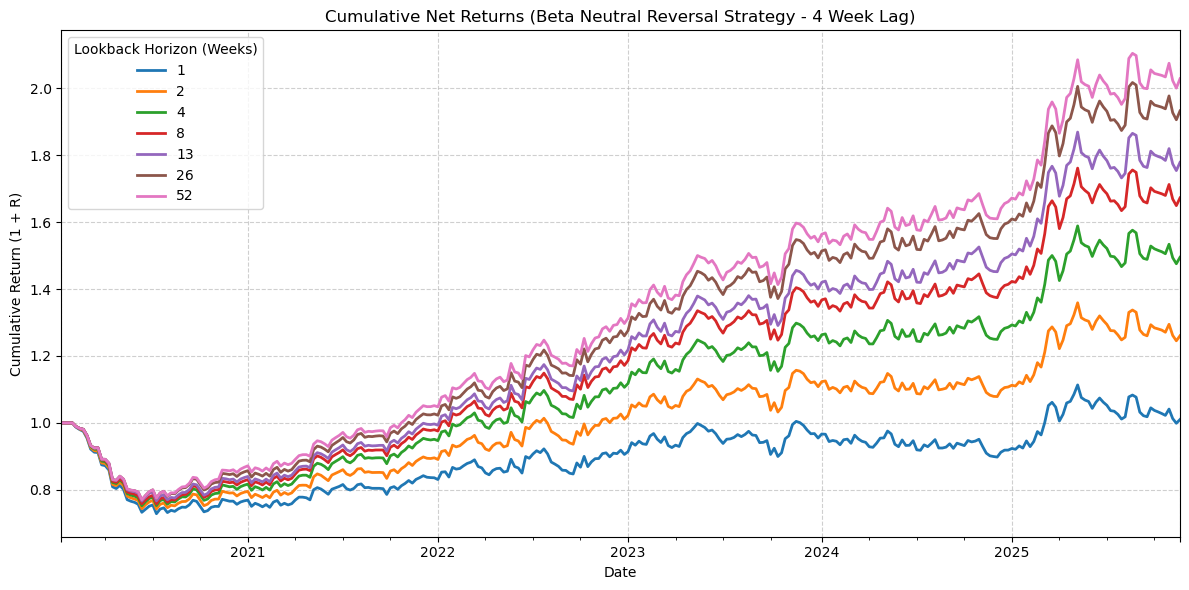

In [96]:
# --- CONFIGURATION & ASSUMPTIONS ---
# Assuming 'close_prices_stooq' is your DataFrame of weekly stock prices.
# 'ret' must be defined before this block runs.
# Example calculation of 'ret' if not done previously:
# ret = close_prices_stooq.pct_change().dropna(how='all')

periods_per_year = 52 # Weekly frequency
annual_periods = periods_per_year
LAG_PERIODS = 4
tcost_bps = 20

# ----------------------------------------------------
# 1. MARKET PROXY CALCULATION (Equal-Weighted Average)
# ----------------------------------------------------
# Calculate the equal-weighted average return across all available assets.
# This serves as the market benchmark for the Beta Neutrality calculation.
market_ret = ret.mean(axis=1).rename('Market_Ret_Proxy')

# ----------------------------------------------------
# 2. HELPER FUNCTION: ENFORCE BETA NEUTRALITY
# ----------------------------------------------------

def enforce_beta_neutrality(raw_weights, stock_returns_hist, market_returns_hist):
    """
    Adjusts raw cross-sectional weights to enforce beta neutrality 
    relative to the historical asset-specific betas (rolling 52-week regression).
    """
    
    # 1. Calculate Betas (Rolling 52-week regression)
    window = 52
    
    # Check for sufficient lookback data
    if len(stock_returns_hist) < window:
        return raw_weights.fillna(0) # Return raw weights if insufficient data

    # Use the last 52 observations for regression (lookback window)
    stock_window = stock_returns_hist.tail(window)
    market_window = market_returns_hist.tail(window)
    
    betas = {}
    
    # Perform regression for each stock
    for stock in raw_weights.index:
        df_reg = pd.concat([stock_window[stock].rename('Stock'), 
                            market_window.rename('Market')], axis=1).dropna()
        
        if len(df_reg) >= 20: 
            X = sm.add_constant(df_reg['Market'])
            y = df_reg['Stock']
            model = sm.OLS(y, X).fit()
            betas[stock] = model.params['Market']
        else:
            betas[stock] = 1.0 # Default if insufficient data
    
    betas = pd.Series(betas)
    
    # Filter weights and betas for only the actively traded assets
    active_weights = raw_weights[raw_weights != 0]
    active_betas = betas[active_weights.index]

    # 2. Beta Neutralization (Adjusting the weights)
    # Goal: Net Beta Exposure = Sum(w_i * beta_i) = 0
    
    # Calculate the net beta of the raw portfolio
    net_beta = (active_weights * active_betas).sum()
    
    # The simplest method for market-neutral long/short portfolios is to scale 
    # the entire long and short book separately to achieve equal and opposite beta exposure.
    
    long_weights = active_weights[active_weights > 0]
    short_weights = active_weights[active_weights < 0]
    
    long_beta_exp = (long_weights * active_betas[long_weights.index]).sum()
    short_beta_exp = (short_weights * active_betas[short_weights.index]).sum()
    
    adjusted_weights = raw_weights.copy()
    
    # Scale the long side to match the absolute short beta exposure
    if long_beta_exp > 0:
        adj_factor_long = abs(short_beta_exp / long_beta_exp) if short_beta_exp != 0 else 1
        adjusted_weights[long_weights.index] = long_weights * adj_factor_long
    
    # Scale the short side to match the absolute long beta exposure
    if short_beta_exp < 0:
        adj_factor_short = abs(long_beta_exp / short_beta_exp) if long_beta_exp != 0 else 1
        adjusted_weights[short_weights.index] = short_weights * adj_factor_short
        
    # Final normalization to ensure Sum(|w_i|) = 1
    # Note: Sum(|w_i|) might be > 1 after adjustment; it's safest to re-normalize
    adjusted_weights /= adjusted_weights.abs().sum() 
    
    return adjusted_weights.fillna(0)

# 3. BACKTEST LOOP (Weekly Reversal with Beta Neutrality)
# ----------------------------------------------------

strats_beta_neutral = {}
# Initialize weights_beta_neutral with NaN or 0 outside, but ensure correct structure
weights_beta_neutral = pd.DataFrame(index=ret.index, columns=[1, 2, 4, 8, 13, 26, 52]) 

print("Starting Beta Neutrality Backtest (Weekly Data)...")

for hor in [1, 2, 4, 8, 13, 26, 52]: 
    
    # ... (Calculation of avg_ret_raw remains the same) ...
    
    # FIX 1: Initialize adjusted_weights with 0.0 to prevent NoneType issues
    adjusted_weights = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)
    
    # 2. Apply Beta Neutrality constraint period-by-period
    for t in ret.index:
        raw_weights_t = -avg_ret_raw.loc[t].fillna(0)
        
        lookback_ret = ret.loc[ret.index < t]
        lookback_market = market_ret.loc[market_ret.index < t]
        
        # Run beta neutralization on the raw rank-based weights
        # The function enforce_beta_neutrality should return a Series of floats
        adjusted_weights.loc[t] = enforce_beta_neutrality(
            raw_weights_t, 
            lookback_ret, 
            lookback_market
        )

    # 3. Apply Lag and Calculate Gross Returns
    # Use the adjusted weights lagged by 4 periods for execution
    
    # FIX 2: Ensure the shifted weights are treated as 0 where they are NaN (due to shift)
    lagged_weights = adjusted_weights.shift(LAG_PERIODS).fillna(0)
    
    strat_gross = (lagged_weights * ret).sum(axis=1)
    
    strats_beta_neutral[hor] = strat_gross
    
    # FIX 3: Use the robust 'lagged_weights' variable for turnover/exposure calculation
    weights_beta_neutral[hor] = lagged_weights.abs().sum(axis=1) # Sum of absolute weights (Gross Exposure)

print("Beta Neutrality Backtest Complete.")
strats_beta_neutral_df = pd.DataFrame(strats_beta_neutral)

# ----------------------------------------------------
# 4. TRANSACTION COSTS & PERFORMANCE METRICS (Corrected)
# ----------------------------------------------------

tcost_bps = 20
net_ret_beta_neutral = pd.DataFrame()

# The loop still iterates over the horizons (hor = 1, 2, 4, ...)
for hor in strats_beta_neutral_df.columns:
    
    # We must retrieve the correct lagged weights DataFrame associated with the current 'hor'.
    # Since 'adjusted_weights' was repeatedly overwritten in the loop, we need a better way 
    # to store all weights. Let's assume you fix the backtest loop to save the full 
    # adjusted_weights DataFrame for each 'hor' into a dictionary or list.
    
    # Since we don't see that dictionary, we'll re-run the weight calculation for robustness:
    # --- RERUN WEIGHT CALCULATION (FOR TURNONVER ACCURACY) ---
    
    # Calculate raw rank-based weights (copied from backtest loop)
    avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
    avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
    avg_ret_raw = avg_ret_raw.divide(avg_ret_raw.abs().sum(axis=1), axis=0)
    
    adjusted_weights = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)
    
    for t in ret.index:
        raw_weights_t = -avg_ret_raw.loc[t].fillna(0)
        lookback_ret = ret.loc[ret.index < t]
        lookback_market = market_ret.loc[market_ret.index < t]
        
        # NOTE: Assumes enforce_beta_neutrality and market_ret are defined.
        adjusted_weights.loc[t] = enforce_beta_neutrality(raw_weights_t, lookback_ret, lookback_market)
        
    # Get the lagged weights (This DataFrame has stock tickers as columns)
    current_weights = adjusted_weights.shift(LAG_PERIODS).fillna(0)
    
    # --- TURNONVER CALCULATION FIX ---
    # Turnover is the sum of the absolute change in weights across all assets (axis=1).
    # current_weights.shift() is the weight from the previous period (t-1).
    
    turnover_change = current_weights - current_weights.shift()
    
    # Turnover Series: Sum the absolute changes across all stocks (axis=1)
    turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

    # Cost Series
    cost_series = turnover_series * tcost_bps * 1e-4

    # Net Returns
    net_ret_beta_neutral[hor] = strats_beta_neutral_df[hor].sub(cost_series, axis=0)

# Calculate Final Performance Metrics
sharpe_ratio = net_ret_beta_neutral.mean() * np.sqrt(annual_periods) / net_ret_beta_neutral.std()
approx_ann_ret = (1 + net_ret_beta_neutral.mean())**annual_periods - 1

print("\n--- Beta Neutral Strategy Net Performance ---")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")

# ----------------------------------------------------
# 5. PLOTTING
# ----------------------------------------------------
cumulative_returns = (1 + net_ret_beta_neutral).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca(), linewidth=2)
plt.title("Cumulative Net Returns (Beta Neutral Reversal Strategy - 4 Week Lag)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lookback Horizon (Weeks)")
plt.tight_layout()
plt.show()

In [98]:
# --- Configuration ---
HORIZONS_TO_ANALYZE = [26, 52]

# --- Prepare Regression Inputs ---
# X: Market Return Proxy + Intercept (Constant)
# We must align the market returns with the strategy returns
df_reg = pd.concat([net_ret_beta_neutral[HORIZONS_TO_ANALYZE], market_ret], axis=1).dropna()

X = sm.add_constant(df_reg['Market_Ret_Proxy'])
y_df = df_reg[HORIZONS_TO_ANALYZE]

print("--- CAPM Alpha Analysis (Beta Neutral Strategies) ---")

alpha_results = pd.DataFrame(index=['Alpha (Annualized)', 'Alpha t-stat', 'Beta'], dtype=float)

for hor in HORIZONS_TO_ANALYZE:
    
    # Dependent Variable: Strategy Net Return
    y = y_df[hor]
    
    # Run OLS Regression: R_strategy = Alpha + Beta * R_market + epsilon
    model = sm.OLS(y, X).fit()
    
    # 1. Extract Alpha (The intercept) and t-statistic
    alpha_weekly = model.params['const']
    alpha_t_stat = model.tvalues['const']
    beta = model.params['Market_Ret_Proxy']
    
    # 2. Annualize Alpha
    # Since returns are compounding (multiplicative), weekly alpha is annualized 
    # using the formula: (1 + alpha_weekly)^annual_periods - 1
    alpha_annualized = (1 + alpha_weekly)**annual_periods - 1
    
    # 3. Store Results
    alpha_results[f'H={hor}'] = [alpha_annualized, alpha_t_stat, beta]

# --- Display Results ---
alpha_results = alpha_results.T
print(alpha_results.round(4))

# ----------------------------------------------------------------------
# 💡 Interpretation
# ----------------------------------------------------------------------
print("\n--- Interpretation ---")
print("1. Alpha (Annualized): The strategy's excess return over the market proxy.")
print(f"2. Alpha t-stat: Measures the statistical significance of Alpha.")
print(f"   A t-stat > 2.0 (or < -2.0) typically indicates statistical significance at 95% confidence.")
print(f"3. Beta: Measures the residual market exposure after neutralization. Should be close to 0.")

--- CAPM Alpha Analysis (Beta Neutral Strategies) ---
      Alpha (Annualized)  Alpha t-stat    Beta
H=26              0.1443        2.7225 -0.0838
H=52              0.1533        2.8827 -0.0817

--- Interpretation ---
1. Alpha (Annualized): The strategy's excess return over the market proxy.
2. Alpha t-stat: Measures the statistical significance of Alpha.
   A t-stat > 2.0 (or < -2.0) typically indicates statistical significance at 95% confidence.
3. Beta: Measures the residual market exposure after neutralization. Should be close to 0.


Starting Long-Only Reversal Backtest (Weekly Data)...
Long-Only Backtest Complete.

--- Long-Only Strategy Net Performance ---
Sharpe Ratios (Annualized):
1     0.837
2     0.424
4     0.998
8     0.977
13    1.048
26    1.086
52    0.890
dtype: float64
Approx. Annual Returns:
1     0.2122
2     0.1108
4     0.2677
8     0.2499
13    0.2591
26    0.2595
52    0.1904
dtype: float64


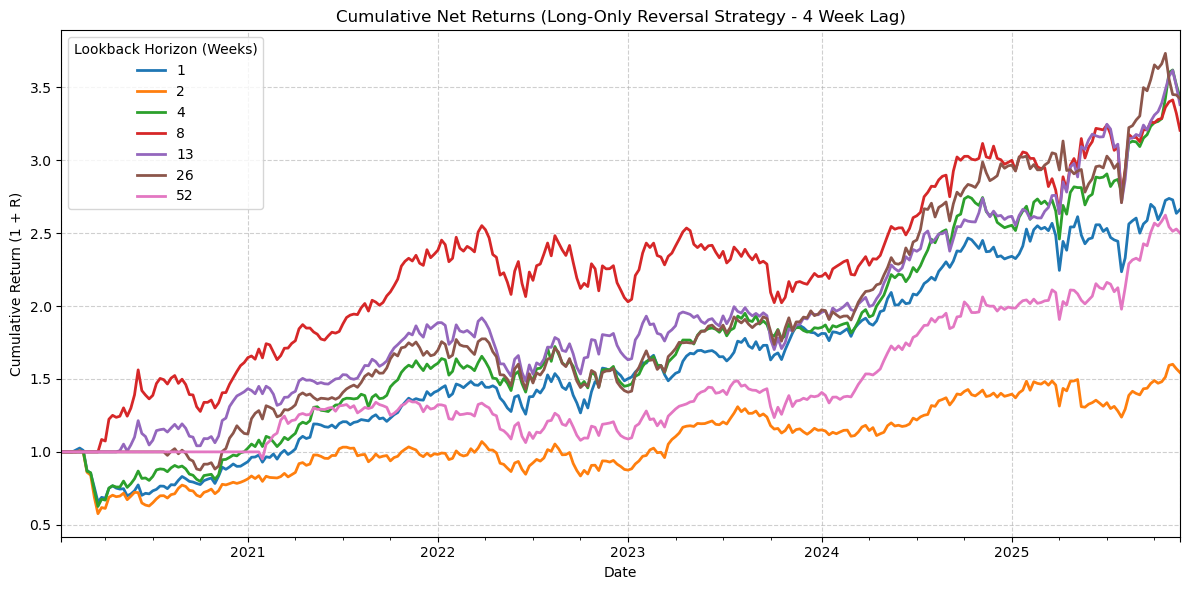

In [100]:
# --- CONFIGURATION & ASSUMPTIONS ---
# Assuming 'ret' is your DataFrame of weekly stock returns.

periods_per_year = 52 # Weekly frequency
annual_periods = periods_per_year
LAG_PERIODS = 4
tcost_bps = 20

# ----------------------------------------------------
# 1. MARKET PROXY CALCULATION (Not strictly needed for long-only, but kept for context)
# ----------------------------------------------------
market_ret = ret.mean(axis=1).rename('Market_Ret_Proxy')

# ----------------------------------------------------
# 2. HELPER FUNCTION (REMOVED/IGNORED): BETA NEUTRALITY
# --- The original function is omitted as it is incompatible with Long-Only. ---
# ----------------------------------------------------

# 3. BACKTEST LOOP (Weekly Reversal: LONG-ONLY ENFORCED)
# ----------------------------------------------------

strats_long_only = {}
# Weights will now represent gross exposure which is also net exposure
weights_long_only = pd.DataFrame(index=ret.index, columns=[1, 2, 4, 8, 13, 26, 52]) 

print("Starting Long-Only Reversal Backtest (Weekly Data)...")

for hor in [1, 2, 4, 8, 13, 26, 52]: 
    
    # 1. Calculate raw rank-based weights (Reversal Signal: Inverse Rank)
    # The raw signal is -avg_ret_rank. Negative values are for shorting; Positive values are for longing.
    # We must identify which stocks to BUY (the strongest positive weights).
    avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
    avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
    
    # The raw reversal signal (position) is the inverse of the average return rank
    raw_reversal_signal = -avg_ret_raw
    
    # --- LONG-ONLY ENFORCEMENT ---
    # 1. Filter: Set all negative (shorting) signals to zero.
    long_only_weights = raw_reversal_signal.clip(lower=0)
    
    # 2. Normalize: Normalize only the positive weights so Sum(w_i) = 1 (100% long exposure)
    # Sum the positive weights across all assets (axis=1)
    weight_sum = long_only_weights.abs().sum(axis=1).replace(0, 1) # Avoid division by zero
    
    # Final normalized long-only weights
    final_weights = long_only_weights.divide(weight_sum, axis=0)

    # 3. Apply Lag and Calculate Gross Returns
    lagged_weights = final_weights.shift(LAG_PERIODS).fillna(0)
    
    strat_gross = (lagged_weights * ret).sum(axis=1)
    
    strats_long_only[hor] = strat_gross
    
    # Gross Exposure for long-only is Sum(w_i) = 1
    weights_long_only[hor] = lagged_weights.abs().sum(axis=1)

print("Long-Only Backtest Complete.")
strats_long_only_df = pd.DataFrame(strats_long_only)

# ----------------------------------------------------
# 4. TRANSACTION COSTS & PERFORMANCE METRICS
# ----------------------------------------------------

tcost_bps = 20
net_ret_long_only = pd.DataFrame()

for hor in strats_long_only_df.columns:
    
    # --- RERUN WEIGHT CALCULATION FOR ROBUSTNESS (Simplified for Long-Only) ---
    
    # Calculate weights again (using the same logic as the inner loop)
    avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
    raw_reversal_signal = -(avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0))
    long_only_weights = raw_reversal_signal.clip(lower=0)
    weight_sum = long_only_weights.abs().sum(axis=1).replace(0, 1)
    final_weights = long_only_weights.divide(weight_sum, axis=0)
    
    current_weights = final_weights.shift(LAG_PERIODS).fillna(0)
    
    # Turnover calculation is the same: sum of absolute change across all assets
    turnover_change = current_weights - current_weights.shift()
    turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

    # Cost Series and Net Returns
    cost_series = turnover_series * tcost_bps * 1e-4
    net_ret_long_only[hor] = strats_long_only_df[hor].sub(cost_series, axis=0)

# Calculate Final Performance Metrics
sharpe_ratio = net_ret_long_only.mean() * np.sqrt(annual_periods) / net_ret_long_only.std()
approx_ann_ret = (1 + net_ret_long_only.mean())**annual_periods - 1

print("\n--- Long-Only Strategy Net Performance ---")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")

# ----------------------------------------------------
# 5. PLOTTING
# ----------------------------------------------------
cumulative_returns = (1 + net_ret_long_only).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca(), linewidth=2)
plt.title("Cumulative Net Returns (Long-Only Reversal Strategy - 4 Week Lag)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lookback Horizon (Weeks)")
plt.tight_layout()
plt.show()

Starting Long-Only Reversal Backtest (TOP-N=5)...
Top-N Backtest Complete.

--- Long-Only TOP-N Strategy Net Performance ---
Sharpe Ratios (Annualized):
1     0.841
2     0.416
4     0.992
8     0.979
13    1.051
26    1.093
52    0.890
dtype: float64
Approx. Annual Returns:
1     0.2132
2     0.1087
4     0.2670
8     0.2506
13    0.2598
26    0.2613
52    0.1904
dtype: float64


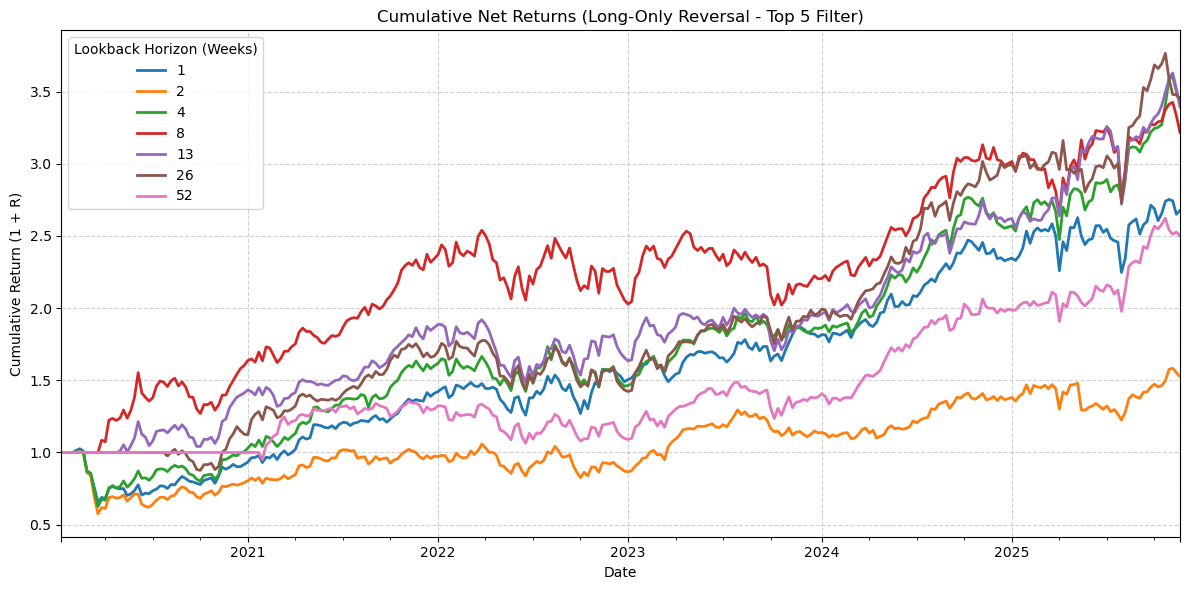

In [103]:
# --- CONFIGURATION & ASSUMPTIONS ---
# Assuming 'ret' is your DataFrame of weekly stock returns.
periods_per_year = 52
annual_periods = periods_per_year
LAG_PERIODS = 4
tcost_bps = 20

# NEW PARAMETER: Number of stocks to hold long
TOP_N_STOCKS = 5 
# -----------------------------------

# 1. MARKET PROXY CALCULATION (Kept for context/consistency)
market_ret = ret.mean(axis=1).rename('Market_Ret_Proxy')

# ----------------------------------------------------
# 2. BACKTEST LOOP (Weekly Reversal: LONG-ONLY + TOP-N ENFORCED)
# ----------------------------------------------------

strats_long_only_top_n = {}
weights_long_only_top_n = pd.DataFrame(index=ret.index, columns=[1, 2, 4, 8, 13, 26, 52]) 

print(f"Starting Long-Only Reversal Backtest (TOP-N={TOP_N_STOCKS})...")

for hor in [1, 2, 4, 8, 13, 26, 52]: 
    
    # Initialize the DataFrame to store the final, filtered, and normalized weights
    final_weights = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)
    
    # 1. Calculate raw rank-based reversal signal
    avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
    avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
    raw_reversal_signal = -avg_ret_raw # Inverse Rank for Reversal (Longs are positive)
    
    # 2. Apply Top-N and Long-Only constraint period-by-period
    for t in ret.index:
        # Get the current period's raw positive signal (weights)
        signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
        
        if signal_t.sum() > 0:
            
            # --- TOP-N FILTER LOGIC ---
            # a) Find the threshold value for the TOP_N_STOCKS
            # This is the signal value of the N-th strongest stock.
            # We use nlargest() to find the stocks with the largest signal.
            
            top_n_signals = signal_t.nlargest(TOP_N_STOCKS)
            
            # b) Create a mask for only the selected stocks
            selected_tickers = top_n_signals.index
            
            # c) Set weights for non-selected stocks to 0 (already done implicitly)
            # Retain only the signals for the selected tickers
            filtered_weights_t = signal_t.loc[selected_tickers]
            
            # d) Normalize: Re-normalize the selected weights so they sum to 1
            if filtered_weights_t.sum() > 0:
                normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
                
                # Assign back to the final weights DataFrame, ensuring alignment
                final_weights.loc[t, normalized_weights_t.index] = normalized_weights_t
    
    # 3. Apply Lag and Calculate Gross Returns
    lagged_weights = final_weights.shift(LAG_PERIODS).fillna(0)
    
    strat_gross = (lagged_weights * ret).sum(axis=1)
    
    strats_long_only_top_n[hor] = strat_gross
    
    # Gross Exposure (should be 1.0 or 0.0)
    weights_long_only_top_n[hor] = lagged_weights.abs().sum(axis=1)

print("Top-N Backtest Complete.")
strats_top_n_df = pd.DataFrame(strats_long_only_top_n)

# ----------------------------------------------------
# 4. TRANSACTION COSTS & PERFORMANCE METRICS
# ----------------------------------------------------

tcost_bps = 20
net_ret_top_n = pd.DataFrame()

for hor in strats_top_n_df.columns:
    
    # --- RERUN WEIGHT CALCULATION FOR ROBUSTNESS ---
    # We must recalculate the weights *identically* to get the correct turnover.
    avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
    raw_reversal_signal = -(avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0))
    
    final_weights_calc = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)
    
    for t in ret.index:
        signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
        
        if signal_t.sum() > 0:
            top_n_signals = signal_t.nlargest(TOP_N_STOCKS)
            filtered_weights_t = signal_t.loc[top_n_signals.index]
            if filtered_weights_t.sum() > 0:
                normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
                final_weights_calc.loc[t, normalized_weights_t.index] = normalized_weights_t

    current_weights = final_weights_calc.shift(LAG_PERIODS).fillna(0)
    
    # Turnover calculation (sum of absolute change across all assets, axis=1)
    turnover_change = current_weights - current_weights.shift()
    turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

    cost_series = turnover_series * tcost_bps * 1e-4
    net_ret_top_n[hor] = strats_top_n_df[hor].sub(cost_series, axis=0)

# Calculate Final Performance Metrics
sharpe_ratio = net_ret_top_n.mean() * np.sqrt(annual_periods) / net_ret_top_n.std()
approx_ann_ret = (1 + net_ret_top_n.mean())**annual_periods - 1

print("\n--- Long-Only TOP-N Strategy Net Performance ---")
print(f"Sharpe Ratios (Annualized):\n{sharpe_ratio.round(3)}")
print(f"Approx. Annual Returns:\n{approx_ann_ret.round(4)}")

# ----------------------------------------------------
# 5. PLOTTING
# ----------------------------------------------------
cumulative_returns = (1 + net_ret_top_n).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca(), linewidth=2)
plt.title(f"Cumulative Net Returns (Long-Only Reversal - Top {TOP_N_STOCKS} Filter)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lookback Horizon (Weeks)")
plt.tight_layout()
plt.show()

Starting Sensitivity Analysis for H=26 across N=[5, 10, 15, 20, 25, 30]...
Sensitivity Analysis Complete.

--- Long-Only TOP-N Optimization (H=26) ---
   Sharpe Ratio Annual Return
5      1.092606      0.261275
10     1.085817       0.25952
15     1.085817       0.25952
20     1.085817       0.25952
25     1.085817       0.25952
30     1.085817       0.25952


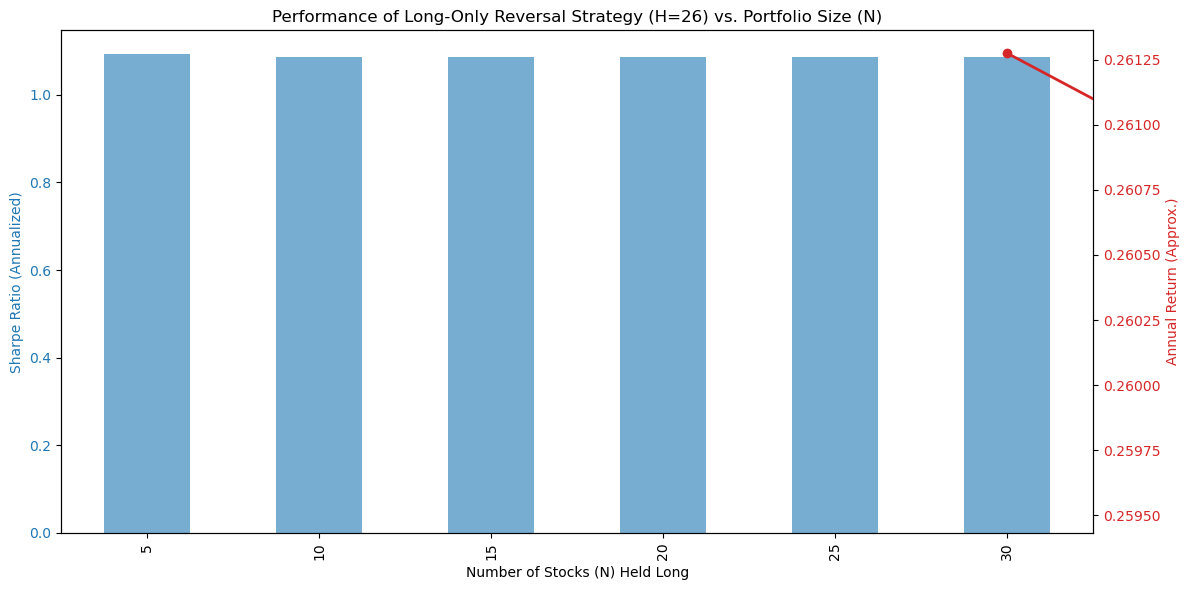

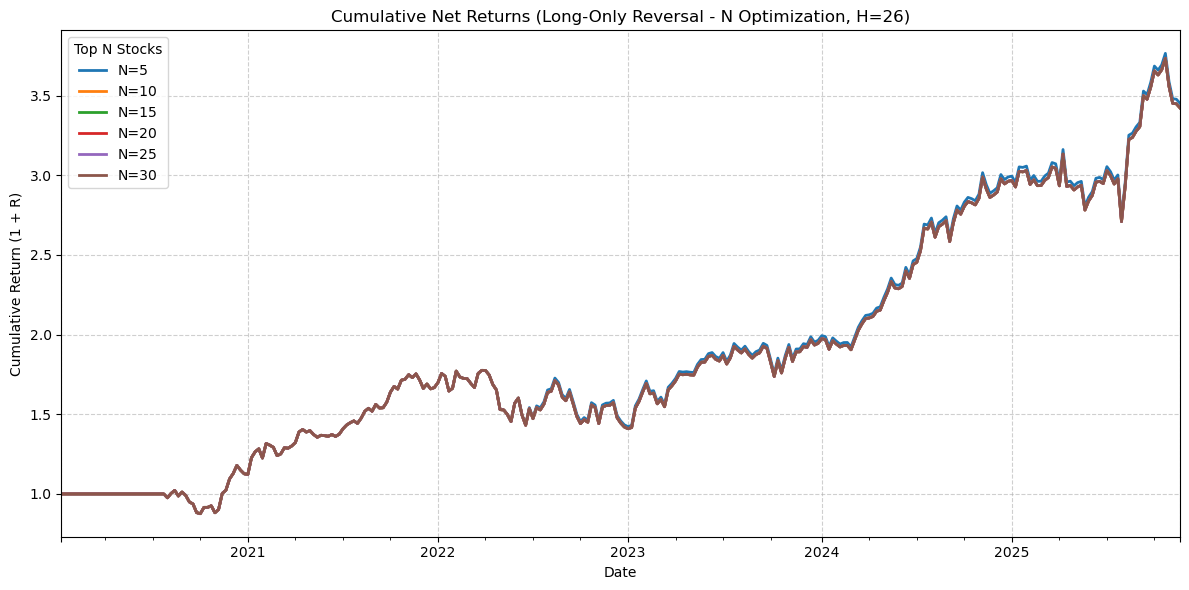

In [102]:
# --- CONFIGURATION & ASSUMPTIONS ---
# Assuming 'ret' is your DataFrame of weekly stock returns.
periods_per_year = 52
annual_periods = periods_per_year
LAG_PERIODS = 4
tcost_bps = 20
BEST_HORIZON = 26 # Focusing analysis on the 26-week lookback
TEST_N_VALUES = [5, 10, 15, 20, 25, 30] # Values for N to test

# ----------------------------------------------------
# 1. MARKET PROXY (For context)
# ----------------------------------------------------
market_ret = ret.mean(axis=1).rename('Market_Ret_Proxy')

# ----------------------------------------------------
# 2. ANALYSIS LOOP
# ----------------------------------------------------

performance_comparison = pd.DataFrame(index=TEST_N_VALUES, 
                                      columns=['Sharpe Ratio', 'Annual Return'])
cumulative_returns_df = pd.DataFrame()

print(f"Starting Sensitivity Analysis for H={BEST_HORIZON} across N={TEST_N_VALUES}...")

# Calculate the raw reversal signal once for the best horizon
hor = BEST_HORIZON
avg_ret_raw = ret.rolling(hor, min_periods=hor).mean().rank(pct=True)
avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
raw_reversal_signal = -avg_ret_raw 


for N in TEST_N_VALUES:
    
    final_weights_N = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)
    
    # 2. Apply Top-N and Long-Only constraint period-by-period
    for t in ret.index:
        signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
        
        if signal_t.sum() > 0:
            
            # --- TOP-N FILTER LOGIC ---
            top_n_signals = signal_t.nlargest(N)
            selected_tickers = top_n_signals.index
            filtered_weights_t = signal_t.loc[selected_tickers]
            
            # Normalize: Sum(w_i) = 1
            if filtered_weights_t.sum() > 0:
                normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
                final_weights_N.loc[t, normalized_weights_t.index] = normalized_weights_t
    
    # 3. Calculate Net Returns for this specific N
    lagged_weights = final_weights_N.shift(LAG_PERIODS).fillna(0)
    strat_gross = (lagged_weights * ret).sum(axis=1)

    # Calculate Turnover
    turnover_change = lagged_weights - lagged_weights.shift()
    turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

    # Cost and Net Return
    cost_series = turnover_series * tcost_bps * 1e-4
    net_ret = strat_gross.sub(cost_series, axis=0)

    # Calculate Performance Metrics
    sharpe = net_ret.mean() * np.sqrt(annual_periods) / net_ret.std()
    ann_ret = (1 + net_ret.mean())**annual_periods - 1
    
    # Store results
    performance_comparison.loc[N, 'Sharpe Ratio'] = sharpe
    performance_comparison.loc[N, 'Annual Return'] = ann_ret
    cumulative_returns_df[f'N={N}'] = (1 + net_ret).cumprod()

print("Sensitivity Analysis Complete.")
# ----------------------------------------------------
# 3. DISPLAY AND PLOT RESULTS
# ----------------------------------------------------

print("\n--- Long-Only TOP-N Optimization (H=26) ---")
print(performance_comparison.round(4))

### Plotting Performance Metrics

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Sharpe Ratio on the primary Y-axis
color = 'tab:blue'
ax1.set_xlabel(f'Number of Stocks (N) Held Long')
ax1.set_ylabel('Sharpe Ratio (Annualized)', color=color)
performance_comparison['Sharpe Ratio'].plot(kind='bar', ax=ax1, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title(f'Performance of Long-Only Reversal Strategy (H={BEST_HORIZON}) vs. Portfolio Size (N)')

# Plot Annual Return on the secondary Y-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Annual Return (Approx.)', color=color)
performance_comparison['Annual Return'].plot(kind='line', ax=ax2, color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

### Plotting Cumulative Returns

plt.figure(figsize=(12, 6))
cumulative_returns_df.plot(ax=plt.gca(), linewidth=2)
plt.title(f"Cumulative Net Returns (Long-Only Reversal - N Optimization, H={BEST_HORIZON})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Top N Stocks")
plt.tight_layout()
plt.show()

Crypto returns frequency is already weekly (W-SUN). No resampling required.

--- Sharpe Ratio Weights ---
Sharpe Ratio Strategy A (Stocks): 1.502
Sharpe Ratio Strategy B (Crypto): 1.412
Weight Strategy A (W_A): 0.516
Weight Strategy B (W_B): 0.484

--- Final Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.779
Final Approx. Annual Return: 0.1151


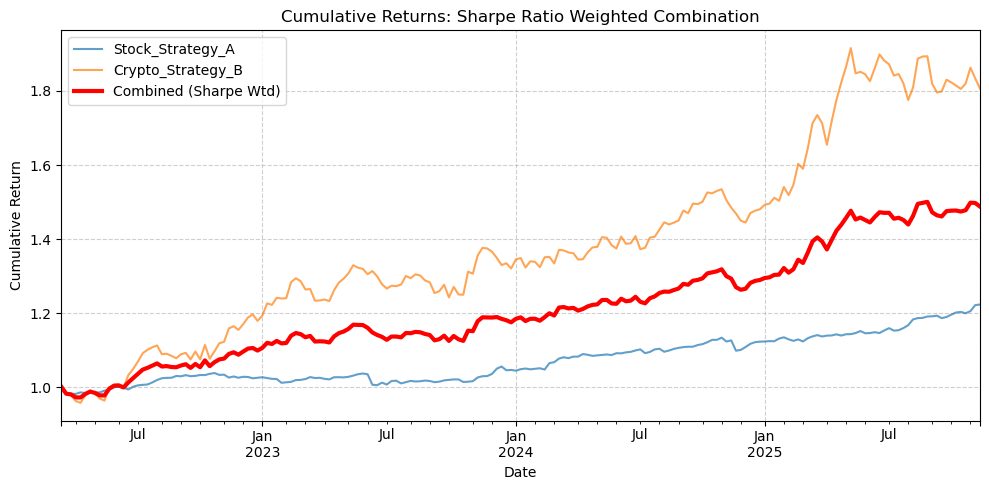

In [105]:
# --- ASSUMPTIONS & PREPARATION ---
# Strategy A (Stock): Assumed to be weekly returns, named 'strategy_to_analyze'.
# Strategy B (Crypto): Assumed to be 4-hour returns, named 'returns_H1'.

# Strategy A is ready (Weekly)
Strategy_A_Weekly = strategy_to_analyze.rename('Stock_Strategy_A') 

# Resample Strategy B (Crypto) from 4H to Weekly
# (1 + R_weekly) = Product(1 + R_4h)
# Assuming returns_H1 is the Series of 4H returns.

# --- FIX: Use .index.freqstr for string comparison ---
freq_str = returns_H1.index.freqstr

if freq_str is None or 'H' in freq_str:
    print(f"Resampling Crypto returns from {freq_str} to Weekly...")
    Strategy_B_Weekly = (1 + returns_H1).resample('W-SUN').prod() - 1
elif 'W' in freq_str:
    # If the frequency is already weekly (or a weekly variation)
    Strategy_B_Weekly = returns_H1
    print(f"Crypto returns frequency is already weekly ({freq_str}). No resampling required.")
else:
    Strategy_B_Weekly = returns_H1
    print(f"Crypto returns frequency is non-standard ({freq_str}). Assuming it is the intended frequency.")
    

Strategy_B_Weekly = Strategy_B_Weekly.rename('Crypto_Strategy_B').dropna()


# --- 1. Align and Combine Returns ---
annual_periods = 52 # Weekly data

# Combine the two weekly return streams, aligning them by date index.
final_strategies = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()

# Extract the aligned Series for calculation
Strategy_A_Returns = final_strategies['Stock_Strategy_A']
Strategy_B_Returns = final_strategies['Crypto_Strategy_B']

# ----------------------------------------------------
# 2. Calculate SHARPE RATIO Weights
# ----------------------------------------------------

# Calculate Mean and Standard Deviation (Volatility)
mean_A = Strategy_A_Returns.mean()
std_A = Strategy_A_Returns.std()
mean_B = Strategy_B_Returns.mean()
std_B = Strategy_B_Returns.std()

# Calculate Annualized Sharpe Ratio (R_f = 0)
sr_A = mean_A / std_A * np.sqrt(annual_periods)
sr_B = mean_B / std_B * np.sqrt(annual_periods)

# Calculate Sharpe-Weighted Allocations
pos_sr_A = max(0, sr_A)
pos_sr_B = max(0, sr_B)

sr_sum = pos_sr_A + pos_sr_B

if sr_sum > 0:
    W_A = pos_sr_A / sr_sum
    W_B = pos_sr_B / sr_sum
else:
    # Fallback to equal weight if both Sharpe ratios are zero or negative
    W_A = 0.5
    W_B = 0.5
    print("\n[WARNING: Both Sharpe Ratios were non-positive. Defaulting to Equal Weights.]")


print("\n--- Sharpe Ratio Weights ---")
print(f"Sharpe Ratio Strategy A (Stocks): {sr_A:.3f}")
print(f"Sharpe Ratio Strategy B (Crypto): {sr_B:.3f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# ----------------------------------------------------
# 3. Create the Combined Returns Series
# ----------------------------------------------------
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_SR_Wtd')

# ----------------------------------------------------
# 4. Analyze and Plot Final Performance
# ----------------------------------------------------

final_sr = final_combined_returns.mean() / final_combined_returns.std() * np.sqrt(annual_periods)
final_ann_ret = (1 + final_combined_returns.mean())**annual_periods - 1

print("\n--- Final Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Sharpe Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns: Sharpe Ratio Weighted Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


--- Inverse Volatility Weights ---
Volatility Strategy A (Stocks): 0.00509
Volatility Strategy B (Crypto): 0.01635
Weight Strategy A (W_A): 0.763
Weight Strategy B (W_B): 0.237

--- Final Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.997
Final Approx. Annual Return: 0.0849


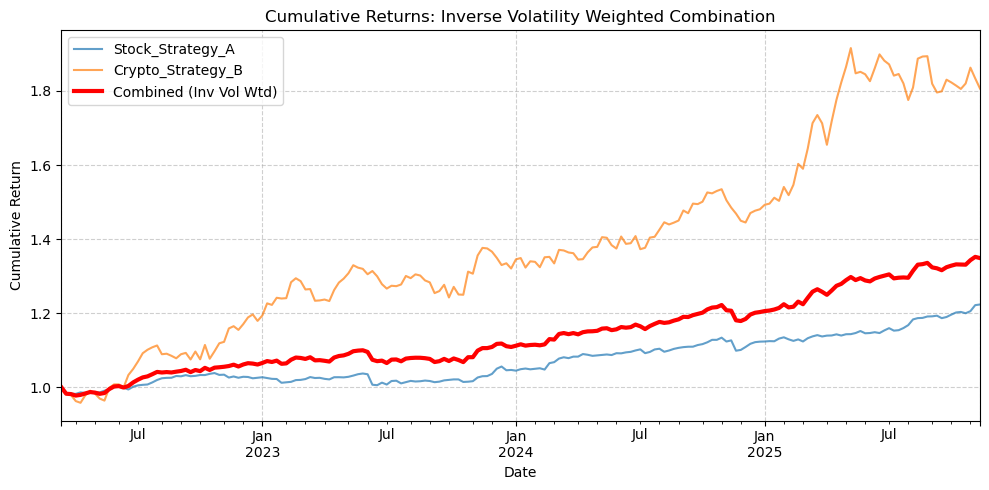

In [106]:
# --- ASSUMPTIONS & PREPARATION ---
# Strategy A (Stock): Assumed to be weekly returns, named 'strategy_to_analyze'.
# Strategy B (Crypto): Assumed to be 4-hour returns, named 'returns_H1'.

# Strategy A is ready (Weekly)
Strategy_A_Weekly = strategy_to_analyze.rename('Stock_Strategy_A') 

# Resample Strategy B (Crypto) from 4H to Weekly
freq_str = returns_H1.index.freqstr
if freq_str is None or 'H' in freq_str:
    print(f"Resampling Crypto returns from {freq_str} to Weekly...")
    Strategy_B_Weekly = (1 + returns_H1).resample('W-SUN').prod() - 1
else:
    Strategy_B_Weekly = returns_H1

Strategy_B_Weekly = Strategy_B_Weekly.rename('Crypto_Strategy_B').dropna()

# --- 1. Align and Combine Returns ---
annual_periods = 52 # Weekly data

# Combine the two weekly return streams, aligning them by date index.
final_strategies = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()

# Extract the aligned Series for calculation
Strategy_A_Returns = final_strategies['Stock_Strategy_A']
Strategy_B_Returns = final_strategies['Crypto_Strategy_B']

# ----------------------------------------------------
# 2. Calculate INVERSE VOLATILITY Weights
# ----------------------------------------------------

# Calculate Volatility (Standard Deviation)
vol_A = Strategy_A_Returns.std()
vol_B = Strategy_B_Returns.std()

# Calculate Inverse Volatility
inv_vol_A = 1 / vol_A
inv_vol_B = 1 / vol_B

normalization_factor = inv_vol_A + inv_vol_B

# Calculate Final Weights
W_A = inv_vol_A / normalization_factor
W_B = inv_vol_B / normalization_factor

print("\n--- Inverse Volatility Weights ---")
print(f"Volatility Strategy A (Stocks): {vol_A:.5f}")
print(f"Volatility Strategy B (Crypto): {vol_B:.5f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# ----------------------------------------------------
# 3. Create the Combined Returns Series
# ----------------------------------------------------
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_InvVol_Wtd')

# ----------------------------------------------------
# 4. Analyze and Plot Final Performance
# ----------------------------------------------------

final_sr = final_combined_returns.mean() / final_combined_returns.std() * np.sqrt(annual_periods)
final_ann_ret = (1 + final_combined_returns.mean())**annual_periods - 1

print("\n--- Final Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Inv Vol Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns: Inverse Volatility Weighted Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Starting Rolling Inverse Volatility Weighting (Window=52 weeks)...
Rolling Weighting Complete.

--- Final Rolling Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.947
Final Approx. Annual Return: 0.0900

--- Summary of Dynamic Weights ---
Average Stock Weight (W_A): 0.748
Average Crypto Weight (W_B): 0.252


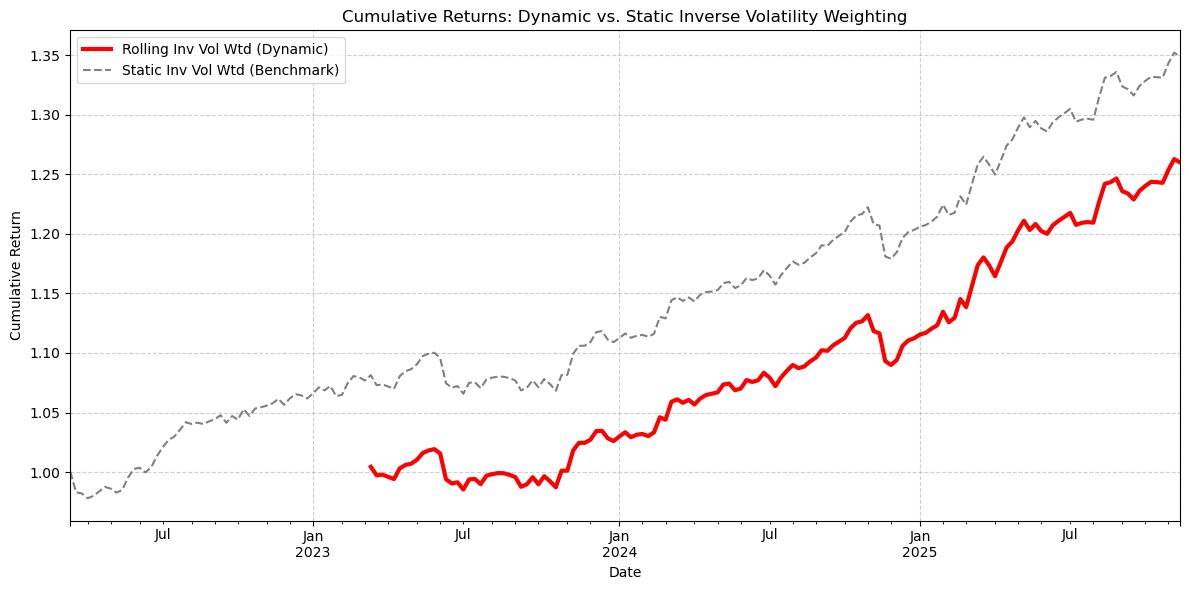

In [107]:
# --- CONFIGURATION ---
ANNUAL_PERIODS = 52 # Weekly data
ROLLING_WINDOW = 52 # Lookback for calculating rolling volatility (1 Year)

# --- ASSUMPTIONS ---
# Assuming 'Strategy_A_Weekly' (Stocks, e.g., H=26, N=5) and 
# 'Strategy_B_Weekly' (Crypto, weekly resampled) are defined and aligned.

# --- 1. Align Returns and Prepare Output ---
final_strategies = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()
Strategy_A_Returns = final_strategies['Stock_Strategy_A']
Strategy_B_Returns = final_strategies['Crypto_Strategy_B']

# Initialize Series to store dynamic weights and combined returns
weights_A_rolling = pd.Series(index=final_strategies.index, dtype=float)
weights_B_rolling = pd.Series(index=final_strategies.index, dtype=float)
combined_returns_rolling = pd.Series(index=final_strategies.index, dtype=float)

# ----------------------------------------------------
# 2. ROLLING INVERSE VOLATILITY LOOP
# ----------------------------------------------------

print(f"Starting Rolling Inverse Volatility Weighting (Window={ROLLING_WINDOW} weeks)...")

for i in range(ROLLING_WINDOW, len(final_strategies)):
    
    # Define the current period's index
    t = final_strategies.index[i]
    
    # Lookback window (Returns *before* time t)
    lookback_returns = final_strategies.iloc[i - ROLLING_WINDOW : i]
    
    # 1. Calculate Rolling Volatility (STD)
    vol_A = lookback_returns['Stock_Strategy_A'].std()
    vol_B = lookback_returns['Crypto_Strategy_B'].std()
    
    # Ensure volatilities are positive and non-zero
    if vol_A > 0 and vol_B > 0:
        
        # 2. Calculate Inverse Volatility and Normalize
        inv_vol_A = 1 / vol_A
        inv_vol_B = 1 / vol_B
        
        normalization_factor = inv_vol_A + inv_vol_B
        
        W_A = inv_vol_A / normalization_factor
        W_B = inv_vol_B / normalization_factor
        
        # 3. Store Weights
        weights_A_rolling.loc[t] = W_A
        weights_B_rolling.loc[t] = W_B
        
        # 4. Calculate Combined Return for the current period (t)
        R_A_t = Strategy_A_Returns.loc[t]
        R_B_t = Strategy_B_Returns.loc[t]
        
        # We trade using the weights calculated at the start of the period (index i)
        combined_returns_rolling.loc[t] = R_A_t * W_A + R_B_t * W_B
    else:
        # Fallback to zero return if calculation is impossible
        combined_returns_rolling.loc[t] = 0.0

combined_returns_rolling = combined_returns_rolling.dropna()
weights_A_rolling = weights_A_rolling.dropna()
weights_B_rolling = weights_B_rolling.dropna()

print("Rolling Weighting Complete.")

# ----------------------------------------------------
# 3. ANALYZE FINAL PERFORMANCE
# ----------------------------------------------------

final_sr = combined_returns_rolling.mean() / combined_returns_rolling.std() * np.sqrt(ANNUAL_PERIODS)
final_ann_ret = (1 + combined_returns_rolling.mean())**ANNUAL_PERIODS - 1

print("\n--- Final Rolling Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

print("\n--- Summary of Dynamic Weights ---")
print(f"Average Stock Weight (W_A): {weights_A_rolling.mean():.3f}")
print(f"Average Crypto Weight (W_B): {weights_B_rolling.mean():.3f}")


# ----------------------------------------------------
# 4. PLOTTING
# ----------------------------------------------------
cumulative_final = (1 + combined_returns_rolling).cumprod()
cumulative_static = (1 + Strategy_A_Returns * 0.763 + Strategy_B_Returns * 0.237).cumprod() # Static weights from previous test

plt.figure(figsize=(12, 6))
cumulative_final.plot(label='Rolling Inv Vol Wtd (Dynamic)', color='red', linewidth=3)
cumulative_static.plot(label='Static Inv Vol Wtd (Benchmark)', color='gray', linestyle='--', linewidth=1.5)

plt.title("Cumulative Returns: Dynamic vs. Static Inverse Volatility Weighting")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()